In [58]:
import os
import warnings
import pickle as pkl
import pathlib

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.legend import Legend

from statsmodels.tsa.stattools import adfuller, acf
from matplotlib import rcParams

from utils import *
from plot_utils import *


In [3]:
def extract_results(self, save = True, normalize = True,):
    """
    Analyse the defects for all the input folders
    """
    for N in range(self.Ndata):

        defect_arr = np.nan * np.zeros((self.Nframes[N], self.Nactivity[N], self.Nexp[N]))
        av_counts = np.nan * np.zeros([self.Nframes[N], len(self.window_sizes[N]), self.Nactivity[N], self.Nexp[N]])
        var_counts = np.nan * np.zeros_like(av_counts)

        if os.path.isfile(os.path.join(self.output_paths[N], 'kbins.txt')):
            ext_sfac = True
            kbins = np.loadtxt(os.path.join(self.output_paths[N], 'kbins.txt'))
            rad = np.load(os.path.join(self.output_paths[N], 'rad.npy'))
            sfac = np.nan * np.zeros((self.Nframes[N], len(kbins), 2, self.Nactivity[N], min(10, self.Nexp[N])))
            pcf = np.nan * np.zeros((self.Nframes[N], len(rad), self.Nactivity[N], min(self.Nexp[N], 10)))
        else:
            ext_sfac = False
        
        print('Analyse defects for input folder {}'.format(self.input_paths[N]))
        for i, (act, act_dir) in enumerate(zip(self.act_list[N], self.act_dir_list[N])):
            sfac_counter = 0
            exp_list = []
            exp_dir_list = []

            for file in os.listdir(act_dir):
                exp_count = file.split('_')[-1]
                exp_list.append(int(exp_count))
                exp_dir_list.append(os.path.join(act_dir, file))

            # sort the activity list and the activity directory list
            exp_list, exp_dir_list = zip(*sorted(zip(exp_list, exp_dir_list)))

            for j, (exp, exp_dir) in enumerate(zip(exp_list, exp_dir_list)):
                defect_arr[:, i, j] = np.loadtxt(os.path.join(exp_dir, 'Ndefects_act{}_exp{}.txt'.format(act, exp)))[-self.Nframes[N]:]

                counts = np.loadtxt(os.path.join(exp_dir, 'av_counts_act{}_exp{}.txt'.format(act,exp)))[-self.Nframes[N]:,:]
                vars = np.loadtxt(os.path.join(exp_dir, 'count_fluctuations_act{}_exp{}.txt'.format(act,exp)))[-self.Nframes[N]:,:]

                idx_start_count = min(self.Nframes[N], len(counts))
                av_counts[-idx_start_count:, :, i, j] = counts[-idx_start_count:, :]
                var_counts[-idx_start_count:, :, i, j] = vars[-idx_start_count:, :]

                if ext_sfac and sfac_counter < 10:
                    try:
                        sfac[-self.Nframes[N]:, :, :, i, sfac_counter] = np.load(os.path.join(exp_dir, 'structure_factor_act{}_exp{}.npy'.format(act,exp)))[-self.Nframes[N]:, :,:]
                    except:
                        pass
                    try:
                        pcf[-idx_start_count:, :, i, sfac_counter] = np.loadtxt(os.path.join(exp_dir, 'pcf.txt'.format(act,exp)))[-self.Nframes[N]:,:]
                    except:
                        pass
                    if os.path.isfile(os.path.join(exp_dir,'sfac_analysis_completed.txt')):
                        sfac_counter += 1
    
        dens_fluc = var_counts / (np.pi * self.window_sizes[N][:, None, None] ** 2) ** 2
        if normalize:
            av_dens = defect_arr / self.LX[N] ** 2
            dens_fluc = dens_fluc / av_dens[:, None, :, :] ** 2

        if save:
            np.save(os.path.join(self.output_paths[N], 'defect_arr.npy'), defect_arr)
            np.save(os.path.join(self.output_paths[N], 'av_counts.npy'), av_counts)
            np.save(os.path.join(self.output_paths[N], 'var_counts.npy'), var_counts)
            np.save(os.path.join(self.output_paths[N], 'dens_fluc.npy'), dens_fluc)

            if ext_sfac:
                np.save(os.path.join(self.output_paths[N], 'sfac.npy'), sfac)
                np.save(os.path.join(self.output_paths[N], 'pcf.npy'), pcf)

def calc_rad_cutoff(rad_arr, pcf_arr_av, pcf_arr_std, alpha_list, cutoff=1e-2, rad_min=40,):

    act_list = alpha_list
    rad_cutoff_arr = np.nan * np.zeros((len(act_list)))

    for i, act in enumerate(act_list):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)

            rad_idx_min = np.where(rad_arr > rad_min)[0][0]
           
            try:
                rad_cutoff_idx = np.where(np.abs(pcf_arr_av[i, rad_idx_min:]) - pcf_arr_std[i, rad_idx_min:] < cutoff)[0][0] + rad_idx_min
                rad_cutoff_arr[i] = rad_arr[rad_cutoff_idx]
            except:
                pass
    return rad_cutoff_arr

def plot_structure_factor(kbins, smeans, sstds, k = None, LX = None, scaling_exp_list=[], scaling_label_list=[], Npoints_to_fit=10, ax=None, sf_estimated = None):
    """
    Plot structure factor
    """

    k_begin_lines_idx = Npoints_to_fit - 1  
    kmin, kmax = np.nanmin(kbins), np.nanmax(kbins)
    sf_min, sf_max = np.nanmin(smeans), np.nanmax(smeans)
    x = np.linspace(kmin, kbins[k_begin_lines_idx], 10)

    if ax is None:
        fig, ax = plt.subplots(figsize=(9, 6))
        subplot = False
    else:
        subplot = True


    if k and sf_estimated:
        ax.scatter(np.linalg.norm(k, axis = 1), sf_estimated, label='Structure factor', s=2.5, alpha=0.3)

    ax.hlines(1, x[0], kmax, linestyles='dashed', colors='k')
    ax.errorbar(kbins, smeans, yerr = sstds, fmt = 's-', alpha = .5, color = 'red', ecolor = 'black', markersize = 3)

    if len(scaling_exp_list) > 0:
        x = kbins[:Npoints_to_fit]
        scaling_exp = scaling_exp_list[i]
        label = scaling_label_list[i] if len(scaling_label_list) > 0 else None
        ax.plot(x, smeans[k_begin_lines_idx] * x**scaling_exp / x[-1]**scaling_exp, '--', color='k',lw=2, label = label, alpha=1,) 
 
    ax.set_xscale('log')
    ax.set_yscale('log')

    if LX == 2048:
            ax.set_xticks([kmin, 0.01, 0.1, kmax], [np.round(kmin,3), 0.01, 0.1, np.round(kmax,1)])
            ax.set_yticks([0.3, 0.4, 0.6, 1, 5], [0.3, 0.4, 0.6, 1, 5])
    else:
        ax.set_xticks([kmin, 0.1, kmax], [np.round(kmin,3), 0.1, np.round(kmax,1)])
    #    ax.set_yticks([0.3, 0.4, 0.6, 1,], [0.3, 0.4, 0.6, 1,])

    if subplot:
        return ax
    else:
        ax.legend(ncol=3, fontsize = 14)
        ax.set_xlabel(r'Norm of wavenumber ($k$)')
        ax.set_ylabel(r'Time av. structure factor')
        fig.tight_layout()
        return fig, ax
    
def analyze_sfac_time_av(kbins, sfac_av, Npoints_bounds = [3,8],):
    """
    returns fit_params_time_av
    """

    def fit_func(x, alpha, beta):
                return beta + alpha * x
    param_guess = np.array([0.1, 0.1])
    fit_string = rf'$y = \beta + \alpha |k|$'
    Nparams = len(param_guess)
    Nact = sfac_av.shape[1]

    fit_params_sfac_time_av = np.zeros([Nact, 2 * Nparams]) * np.nan

    for i in range(Nact):
        try:
            x = np.log(kbins)
            y = np.log(sfac_av[:, i, 0])
            yerr = sfac_av[:, i, 1] / sfac_av[:, i, 0] 
        except:
            continue

        fit_vals = np.nan * np.zeros((Npoints_bounds[1] - Npoints_bounds[0], Nparams))
        fit_err = np.nan * np.zeros((Npoints_bounds[1] - Npoints_bounds[0], Nparams))

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=np.VisibleDeprecationWarning)
            for j, Npoints_to_fit in enumerate(range(Npoints_bounds[0], Npoints_bounds[1])):         
                
                fit = do_chi2_fit(fit_func, x[:Npoints_to_fit], y[:Npoints_to_fit], yerr[:Npoints_to_fit],
                                   param_guess, verbose = False)
                
                fit_vals[j] = fit.values[:] if fit._fmin.is_valid else [np.nan, np.nan]
                fit_err[j] = fit.errors[:] if fit._fmin.is_valid  else [np.nan, np.nan]
            nan_mask = np.isnan(fit_vals[:,0])
            fit_vals_valid = fit_vals[~nan_mask]
            fit_err_valid = fit_err[~nan_mask]
         #   print(i)
         #   print(fit_vals[:,0])
         #   print(fit_err[:,0])
            if len(fit_vals_valid) == 0 or len(fit_err_valid) == 0:
                continue
            alpha_weighted_av, alpha_sem = calc_weighted_mean(fit_vals_valid[:,0], fit_err_valid[:,0])
            beta_weighted_av, beta_sem = calc_weighted_mean(fit_vals_valid[:,1], fit_err_valid[:,1])
            alpha_std, beta_std = np.std(fit_vals_valid, axis = 0)

          #  print("\n",alpha_weighted_av, np.nanmean(fit_vals_valid[:,0]))
           # print(alpha_sem, alpha_std / np.sqrt(fit_vals_valid.shape[0]))
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            fit_params_sfac_time_av[i, :Nparams] = alpha_weighted_av, beta_weighted_av
            fit_params_sfac_time_av[i, Nparams:] = alpha_sem, beta_sem
   
    return fit_params_sfac_time_av

def calc_susceptibility(defect_arr, av_defects, conv_list, Nscale = True,): 

    def_arr = defect_arr.astype(float)  
    av_def = av_defects.astype(float)
    
    Nact = def_arr.shape[-1]

    # Initialize arrays
    sus = np.zeros((Nact, 2)) * np.nan

   # if Nscale:
    #    def_arr = def_arr / av_def[:, 0][None, :]

    for i in range(Nact):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            Nfirst_frame = int(conv_list[i]) #if Nframes is None else max(def_arr.shape[0] - Nframes, conv_list[i])
            sus[i,0] = np.nanmean(def_arr[Nfirst_frame:, i] ** 2) - np.nanmean(def_arr[Nfirst_frame:, i]) ** 2
    if Nscale:
        sus /= av_def[:, 0][:, None]
        sus[:,1] = np.sqrt(sus[:,0]/av_def[:,0]) * av_def[:,1]

    return sus

def calc_binder(order_param, av_defects, conv_list, tau_arr, tau_simple=False,):
    
    Nact = av_defects.shape[0]   

    binder_cumulants = np.zeros((Nact, 2)) * np.nan
    p4 = order_param** 4
    p2 = order_param ** 2

    p4_av = np.zeros_like(binder_cumulants)
    p2_av = np.zeros_like(binder_cumulants)

    for i, act in enumerate(act_list):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)

            Nfirst_frame = int(conv_list[i])

            Npoints = p4[Nfirst_frame:,i].size/tau_arr[i, 1 if tau_simple else 0]

     
            p4_av[i, 0] = np.nanmean(np.nanmean(p4[Nfirst_frame:,i,]))
            p2_av[i, 0] = np.nanmean(np.nanmean(p2[Nfirst_frame:,i,]))
            p4_av[i, 1] = np.nanstd(p4[Nfirst_frame:,i,]) / np.sqrt(Npoints)
            p2_av[i, 1] = np.nanstd(p2[Nfirst_frame:,i,]) / np.sqrt(Npoints)
        

    # calculate binder cumulants
    binder_cumulants[:,0] = 1 - p4_av[:, 0] / (3 * p2_av[:, 0] ** 2)

    # find the error in the binder cumulant
    dzdx = lambda x, y: - 1 / (3 * y ** 2)
    dzdy = lambda x, y: 2 * x / (3 * y ** 3)

    correlation = calc_corr_matrix(np.array([p4_av[:,0], p2_av[:,0]]).T)[0,1]
    binder_cumulants[:,1] = prop_err(dzdx, dzdy, p4_av[:,0], p2_av[:,0], p4_av[:,1], p2_av[:,1], correlation = correlation)

    return binder_cumulants

def analyze_hyperuniformity(window_sizes, var_arr_time_av, var_arr_time_std, fit_dict = {}, window_idx_bounds = None, \
                            act_idx_bounds = None,):
    

    if window_idx_bounds is None:
        window_idx_bounds = [0, None]
    if act_idx_bounds is None:
        act_idx_bounds = [0, None]

    windows = window_sizes[window_idx_bounds[0]:window_idx_bounds[1]]

    var_av = var_arr_time_av[:, window_idx_bounds[0]:window_idx_bounds[1],]
    var_std = var_arr_time_std[:, window_idx_bounds[0]:window_idx_bounds[1],]

    if fit_dict == {}:
        def fit_func(x, alpha, beta):
            return beta * (2 - alpha) + (2 - alpha) * x
        param_guess = np.array([100, -.4])
        fit_string = rf'$y = \beta(2-\alpha) + (2-\alpha)x$'
    else:
        fit_func = fit_dict['fit_func']
        param_guess = fit_dict['param_guess']
        fit_string = fit_dict['fit_string']

    Nparams = len(param_guess)
        
    fit_params = np.zeros([len(act_list), 2 * Nparams]) * np.nan
    stat_arr = np.zeros([len(act_list), 3]) * np.nan
    alpha_list = np.zeros([len(act_list), 2]) * np.nan

    for i in range(var_av.shape[0]):

        count_var_av = var_av[i,:]
        count_var_std = var_std[i,:]
        zero_mask = (count_var_av > 0) & (count_var_std > 0)
    
  
        if len(count_var_av[zero_mask]) < 5:
            print('Not enough data points')
            continue

        try:
            x = np.log(windows[zero_mask])
            y = np.log(count_var_av[zero_mask])
            yerr = count_var_std[zero_mask] / count_var_av[zero_mask]
        except:
            print('Not enough data points2')
            continue
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=np.VisibleDeprecationWarning)
            fit = do_chi2_fit(fit_func, x, y, yerr, param_guess, verbose = False)

        stat_arr[i, :] = get_statistics_from_fit(fit, len(x), subtract_1dof_for_binning = False)
        fit_params[i, :Nparams] = fit.values[:]
        fit_params[i, Nparams:] = fit.errors[:]

    return fit_params, stat_arr

def produce_scaling(X, scaling_exp, Y0, x_bounds,):
    x = X[x_bounds[0]:x_bounds[1]]
    return x, Y0 * x**scaling_exp / x[0]**scaling_exp

#### Extract results and initialize

In [4]:
save_path = 'data\\na_ndg'
if not os.path.isdir(save_path):
        os.mkdir(save_path)
alpha_list = np.arange(0, 0.11,0.01)
# save = True
np.save(os.path.join(save_path,'alpha_list.npy'), alpha_list)

In [4]:
extract = True
save_path = 'data\\na_ndg'
Nframes = 1501

if extract:

    data_path = 'X:\\na_ndgr2'
    data_subdirs = [os.path.join(data_path, subdir) for subdir in os.listdir(data_path)[:]]
    data_subdirs = sorted(data_subdirs, key=lambda x: int(x.split('_')[-1]))

    if not os.path.isdir(save_path):
        os.mkdir(save_path)

    dir0 = data_subdirs[0]
    window_sizes = np.loadtxt(os.path.join(dir0, 'window_sizes.txt'))
    Nsim = len(os.listdir(data_path))
    Nwindows = len(window_sizes)


    av_counts_non = np.nan * np.zeros([Nframes, Nwindows, Nsim])

    for i, dirr in enumerate(data_subdirs):

        vals = np.load(os.path.join(dirr,f'av_counts_nonperiodic.npy'))[-Nframes:]
        av_counts_non[:,:,i] = np.squeeze(vals)
 

    np.save(os.path.join(save_path, 'av_counts_non.npy'), av_counts_non)


In [5]:
extract = False
save_path = 'data\\na_ndg'
Nframes = 1501


if extract:

    data_path = 'X:\\na_ndg'
    data_subdirs = [os.path.join(data_path, subdir) for subdir in os.listdir(data_path)[:]]
    data_subdirs = sorted(data_subdirs, key=lambda x: int(x.split('_')[-1]))

    if not os.path.isdir(save_path):
        os.mkdir(save_path)

    dir0 = data_subdirs[0]
    window_sizes = np.loadtxt(os.path.join(dir0, 'window_sizes.txt'))
    kbins = np.loadtxt(os.path.join(dir0, 'kbins.txt'))
    rad = np.loadtxt(os.path.join(dir0, 'rad.txt'))

    Nsim = len(os.listdir(data_path))
    Nwindows = len(window_sizes)

    defect_arr = np.nan * np.zeros((Nframes, Nsim))
    av_counts = np.nan * np.zeros([Nframes, Nwindows, Nsim])
    var_counts = np.nan * np.zeros_like(av_counts)
    sfac = np.nan * np.zeros((Nframes, len(kbins), 2, Nsim))
    pcf = np.nan * np.zeros((Nframes, len(rad), Nsim))

    for i, dirr in enumerate(data_subdirs):
        defect_arr[:, i] = np.loadtxt(os.path.join(dirr,f'Ndefects_N{i}.txt'))[-Nframes:]
        av_counts[:,:,i] = np.loadtxt(os.path.join(dirr,f'av_counts_act_N{i}.txt'))[-Nframes:]
        var_counts[:,:,i] = np.loadtxt(os.path.join(dirr,f'count_fluctuations_N{i}.txt'))[-Nframes:]
        sfac[:, :, :, i] = np.load(os.path.join(dirr,f'structure_factor_N{i}.npy'))[-Nframes:]
        pcf[:, :, i] = np.load(os.path.join(dirr,f'pcf.npy'))[-Nframes:]

    np.save(os.path.join(save_path, 'window_sizes.npy'), window_sizes)
    np.save(os.path.join(save_path, 'rad.npy'), rad)
    np.save(os.path.join(save_path, 'kbins.npy'), kbins)

    np.save(os.path.join(save_path, 'defect_arr.npy'), defect_arr)
    np.save(os.path.join(save_path, 'av_counts.npy'), av_counts)
    np.save(os.path.join(save_path, 'var_counts.npy'), var_counts)
    np.save(os.path.join(save_path, 'sfac.npy'), sfac)
    np.save(os.path.join(save_path, 'pcf.npy'), pcf)
else: 
    window_sizes = np.load(os.path.join(save_path, 'window_sizes.npy'))
    rad = np.load(os.path.join(save_path, 'rad.npy'))
    kbins = np.load(os.path.join(save_path, 'kbins.npy'))

    conv_list = np.load(os.path.join(save_path, 'conv_list.npy'))
    alpha_list = np.load(os.path.join(save_path, 'alpha_list.npy'))

    defect_arr = np.load(os.path.join(save_path, 'defect_arr.npy'))
    av_counts = np.load(os.path.join(save_path, 'av_counts.npy'))
    var_counts = np.load(os.path.join(save_path, 'var_counts.npy'))
    sfac = np.load(os.path.join(save_path, 'sfac.npy'))
    pcf = np.load(os.path.join(save_path, 'pcf.npy'))

    counts2 = np.load(os.path.join(save_path, 'av_counts2.npy'))
    counts_non = np.load(os.path.join(save_path, 'av_counts_non.npy'))

ninfo = 1000
alpha_max_idx = 10
alpha_list = alpha_list[:alpha_max_idx]
conv_list = conv_list[:alpha_max_idx]

#### Plot defect count and find relaxation time and decorrelation time

In [ ]:
ncols=3
nrows = np.ceil(len(alpha_list) / ncols).astype(int)
fig, ax = plt.subplots(nrows=nrows,ncols=ncols, figsize=(12, 3*nrows))
ax = ax.flatten()
conv_list = np.zeros_like(alpha_list)

for i, alpha in enumerate(alpha_list):

    block_len = 25
    stationarity_dict = dict(interval_len = block_len, Njump = block_len, Nconverged = -400, max_sigma_dist = .5)
    x = est_stationarity(defect_arr[:, i], **stationarity_dict)[0]
    conv_list[i] = x
    ax[i].plot(np.arange(0, Nframes * ninfo, ninfo), defect_arr[:, i], '.',
                alpha = .5, markersize=9, label = rf'$\alpha$ = {alpha}')

    if x > 0:
        ax[i].axvline(x * ninfo, color='black', linestyle='--', alpha=0.5)

 #  ax[i].set_xlabel('Time')
    ax[i].legend()  
    ax[i].grid(True)    

fig.supxlabel('Time')
fig.supylabel('Number of defects')

# save conv list
np.save(os.path.join(save_path, 'conv_list.npy'), conv_list)

In [ ]:
acf_dict = {'nlags_frac': 0.5, 'max_lag': None, 'alpha': 0.3174, 'max_lag_threshold': 0, 'simple_threshold': 0.2}
use_error_bound = False

act_list = alpha_list

ndist_arr = np.zeros((len(act_list), 2)) 
neff_arr = np.zeros((len(act_list)))
neff_arr_simple = np.zeros((len(act_list)))
tau_av_arr = np.nan * np.zeros((len(act_list), 2))


nrows = int(np.ceil(len(act_list) / 3)) #if len(act_list) % 3 != 0 else len(act_list) // 3
fig, ax = plt.subplots(ncols = 3, nrows = nrows, figsize=(16, 4*nrows))
ax = ax.flatten()

acf_arr = np.nan * np.zeros((Nframes + 1, defect_arr.shape[-1]))
confint_arr = np.nan * np.zeros((Nframes + 1, 2, defect_arr.shape[-1]))

for i, alpha in enumerate(alpha_list):

    conv_idx = int(conv_list[i])
    lag_frac = .7
    nf = defect_arr.shape[0] - conv_idx

    conv_val = np.max(conv_list) #if alpha == 0.06 else conv_list[5]
    nlags= int(lag_frac *(Nframes - conv_val)) #int(nf * lag_frac) 
    #nlags =int(nf * lag_frac) 
    frames = np.arange(0, (nlags +1)*ninfo, ninfo)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)

        acf_res, confint = acf(defect_arr[conv_idx:,i], nlags = nlags, alpha = acf_dict['alpha'], missing='conservative')
        acf_arr[-(nlags + 1):, i] = acf_res
        confint_arr[-(nlags + 1):, :, i] = confint

        tau, tau_simple = estimate_effective_sample_size(acf_res, confint_vals=confint,
                                max_lag_threshold=acf_dict['max_lag_threshold'], 
                                simple_threshold=acf_dict['simple_threshold'], 
                                max_lag=acf_dict['max_lag'], use_error_bound=use_error_bound)
    
    #if alpha != 0.06:
    tau_av_arr[i] = tau, tau_simple 

    ax[i].plot(frames, acf_res, '.', alpha=.3, label = rf'$\alpha$ = {alpha}')  
    ax[i].fill_between(frames, confint[:,0], confint[:,1], alpha=.3)
    ax[i].vlines(tau*ninfo, -1, 1, color='black', linestyles='dashed', label=rf'$\tau$ = {tau*ninfo:.2e}')
        
    ax[i].vlines(tau_simple*ninfo, -1, 1, color='red', linestyles='dashed', label='{:.2e}'.format(tau_simple*ninfo))
    ax[i].legend()  


fig.supxlabel('Lag (Timesteps)')
fig.supylabel('Autocorrelation')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


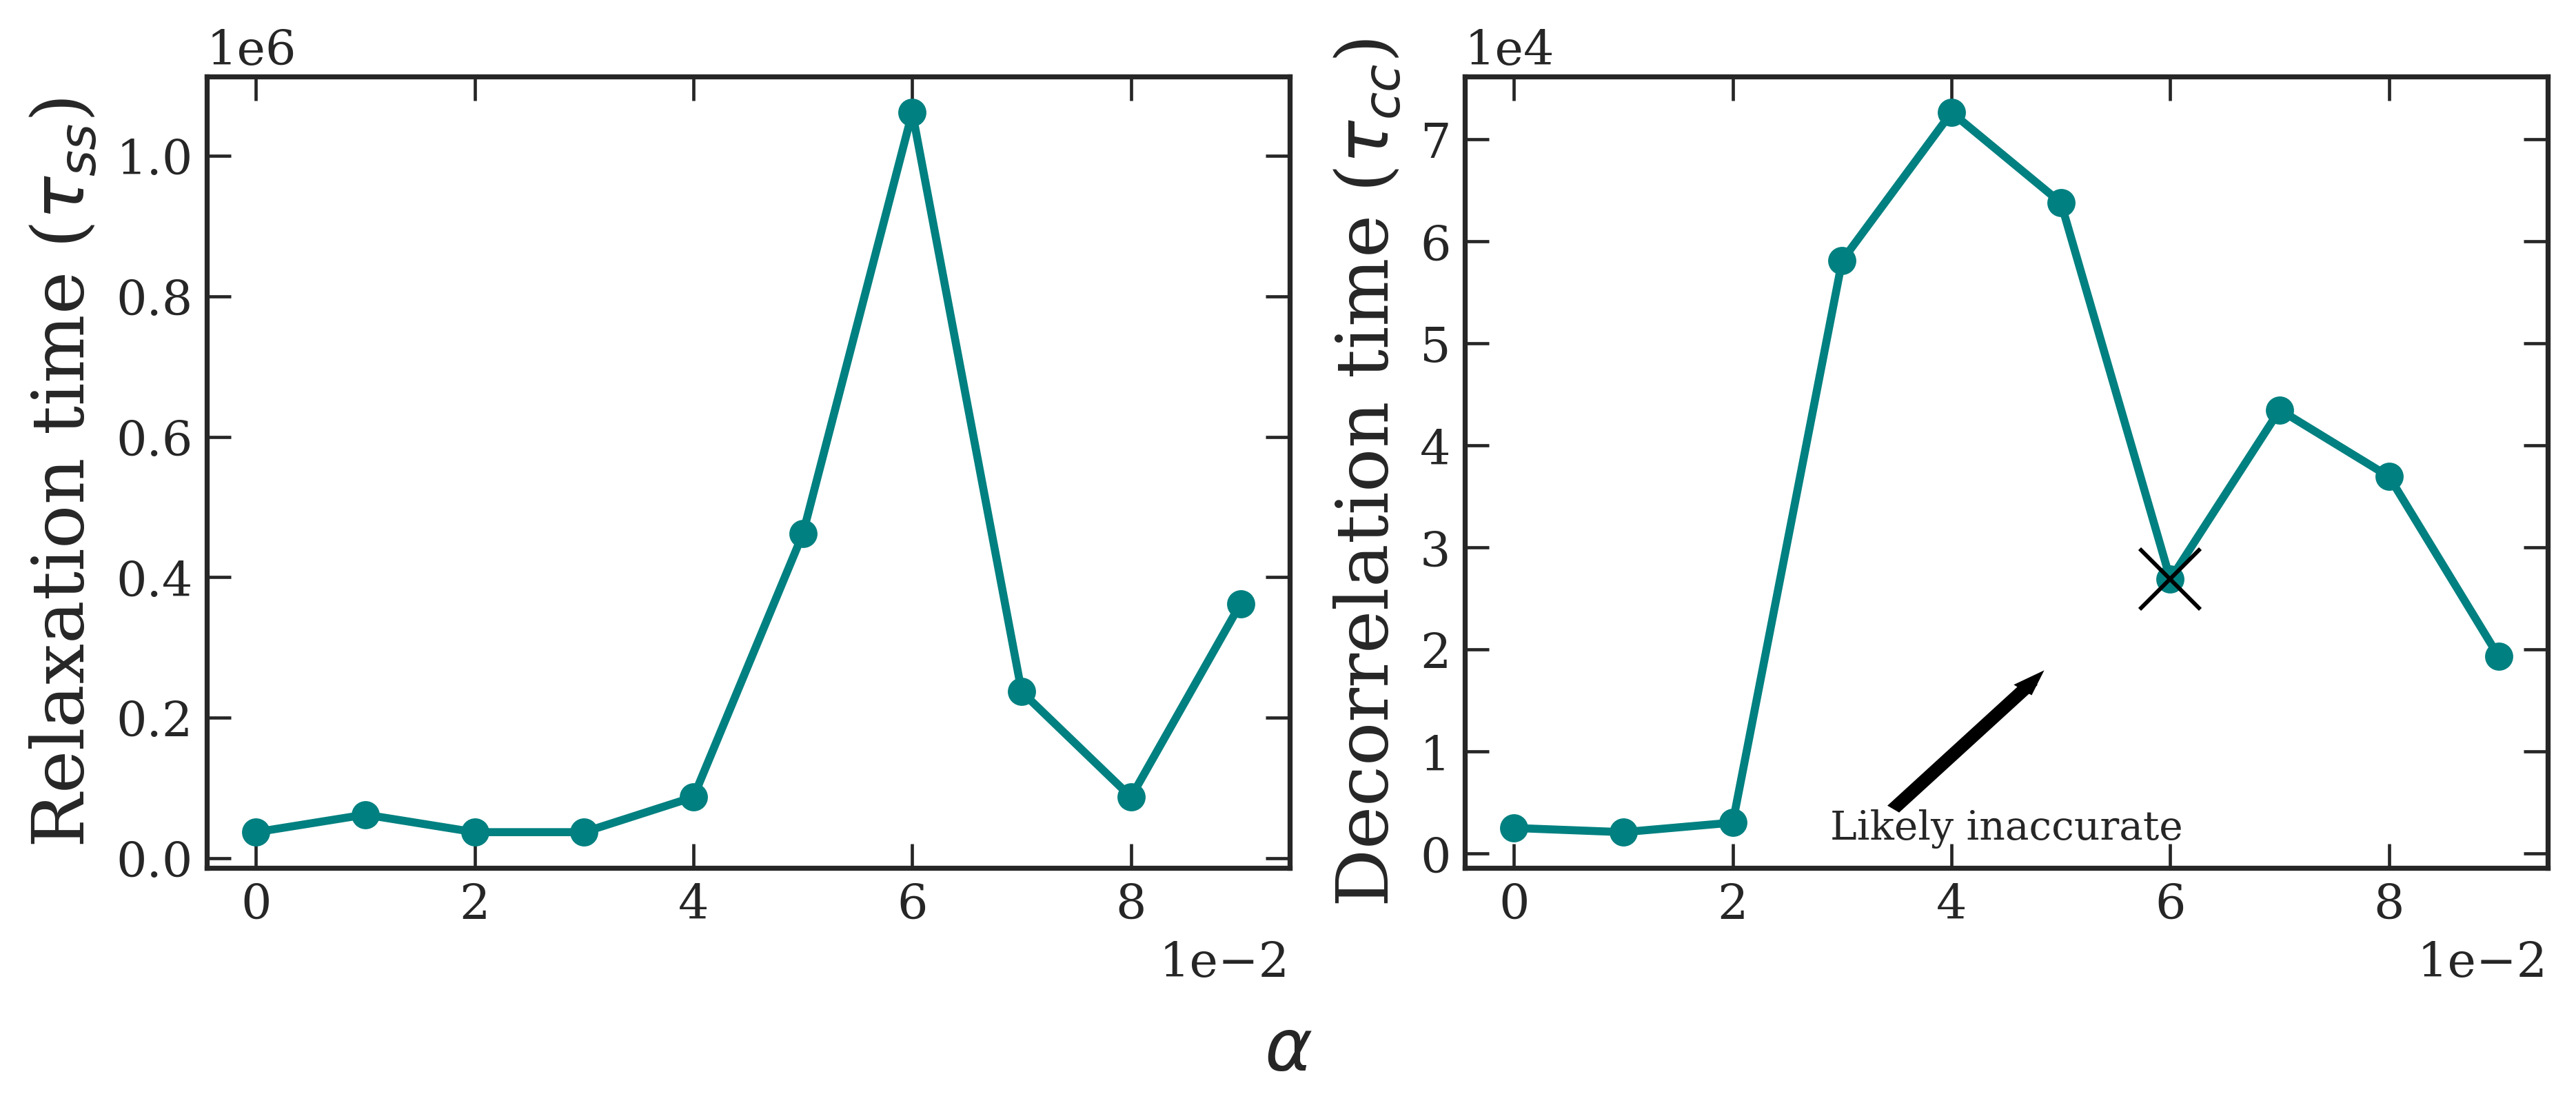

In [7]:
fig, ax = plt.subplots(ncols=2, figsize=(9,4))

ax[0].plot(alpha_list, conv_list*ninfo, 'o-')
ax[0].set_ylabel(r'Relaxation time ($\tau_{ss}$)')    

ax[1].plot(alpha_list, tau_av_arr[:,0] * ninfo, 'o-',)   
ax[1].plot(alpha_list[6], tau_av_arr[6,0] * ninfo, 'kx',ms=15,lw=3)   
#ax[1].plot(alpha_list, tau_av_arr[:,1] * ninfo, '.-', label='tau_simple')
#ax.set_xlabel(r'$alpha$')
ax[1].arrow(0.4, 0.08, .12, .15, transform=ax[1].transAxes, lw = 3)
ax[1].text(0.5, 0.05, f'Likely inaccurate', \
               horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes, fontsize=10)
ax[1].set_ylabel(r'Decorrelation time ($\tau_{cc}$)')
ax[1].legend()
fig.supxlabel(r'$\alpha$',y=0.05)
fig.tight_layout()

#### Calculate other av quantities. We assume that the decorrelation time is the same for all quantities, which is likely an overestimation 

In [7]:
tau_simple = False
Nwindows = av_counts.shape[1]

av_defects = np.nan * np.zeros((len(alpha_list), 2))
var_counts_av = np.nan * np.zeros((len(alpha_list), Nwindows, 2))
av_counts_av = np.nan * np.zeros((len(alpha_list), Nwindows, 2))    
sfac_av = np.nan * np.zeros((len(alpha_list), len(kbins), 2))
pcf_av = np.nan * np.zeros((len(alpha_list), len(rad), 2))

av_counts_av2 = np.nan * np.zeros((len(alpha_list), Nwindows, 2))
var_counts_av2 = np.nan * np.zeros((len(alpha_list), Nwindows, 2))

av_counts_non = np.nan * np.zeros((len(alpha_list), Nwindows, 2))
var_counts_non = np.nan * np.zeros((len(alpha_list), Nwindows, 2))

for i, alpha in enumerate(alpha_list):
    conv_idx = int(conv_list[i])
    nsamples = defect_arr[conv_idx:, i].shape[0] / tau_av_arr[i, 1 if tau_simple else 0]
    av_defects[i] = np.mean(defect_arr[conv_idx:, i]), np.std(defect_arr[conv_idx:, i]) / np.sqrt(nsamples)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        av_counts_av[i, :, 0] = np.mean(av_counts[conv_idx:, :, i], axis=0) 
        av_counts_av[i, :, 1] = np.std(av_counts[conv_idx:, :, i], axis=0) / np.sqrt(nsamples)
        var_counts_av[i,:,0] = np.var(av_counts[conv_idx:, :, i], axis=0) #np.mean(var_counts[conv_idx:, :, i], axis=0), np.std(var_counts[conv_idx:, :, i], axis=0) / np.sqrt(nsamples)

        sfac_av[i, :, 0] = np.nanmean(sfac[conv_idx:, :, 0, i], axis=0)
        sfac_av[i, :, 1] = np.nanstd(sfac[conv_idx:, :, 0, i], axis=0) / np.sqrt(nsamples)

        pcf_av[i, :, 0] = np.nanmean(pcf[conv_idx:, :, i], axis=0)
        pcf_av[i, :, 1] = np.nanstd(pcf[conv_idx:, :, i], axis=0) / np.sqrt(nsamples)

        av_counts_av2[i, :, 0] = np.nanmean(counts2[conv_idx:, :, i], axis=0)
        av_counts_av2[i, :, 1] = np.nanstd(counts2[conv_idx:, :, i], axis=0) / np.sqrt(nsamples)
        var_counts_av2[i,:,0] = np.var(counts2[conv_idx:, :, i], axis=0)

        av_counts_non[i, :, 0] = np.nanmean(counts_non[conv_idx:, :, i], axis=0)
        av_counts_non[i, :, 1] = np.nanstd(counts_non[conv_idx:, :, i], axis=0) / np.sqrt(nsamples)
        var_counts_non[i,:,0] = np.var(counts_non[conv_idx:, :, i], axis=0)

sus = calc_susceptibility(defect_arr[:,:alpha_max_idx], av_defects[:alpha_max_idx,:], conv_list,Nscale=True)
binder_cumulants = calc_binder(defect_arr[:,:alpha_max_idx], av_defects[:alpha_max_idx,:], conv_list, tau_av_arr, tau_simple=False)  


In [37]:
act_idx = -4
conv_idx = int(conv_list[act_idx])

alpha_list[act_idx]

0.06

In [ ]:

fig, ax = plt.subplots(ncols=2, figsize=(9,4))
ff = 25
act_idx = 0
conv_idx = int(conv_list[act_idx])



ax[0].errorbar(np.arange(Nframes), av_counts[:, ff, act_idx,], yerr = np.sqrt(var_counts[:,ff,act_idx,]), fmt='.-', 
            label='Time av. counts', alpha = .5,) 

ax[1].plot(np.arange(Nframes), counts2[:,ff,act_idx,] , '.-', label='Time av. counts', alpha = .5,)
           
print(np.mean(av_counts[:, ff, act_idx,]), np.mean(counts2[:,ff,act_idx,])) 
print(np.mean(av_counts[conv_idx:, ff, act_idx,]), np.mean(counts2[conv_idx:,ff,act_idx,])) 
print(av_counts_av[act_idx, ff, 0], av_counts_av2[act_idx, ff, 0])  
#ax.errorbar(window_sizes, av_counts_av[act_idx,:,0], yerr = var_counts_av[act_idx,:,1], fmt='o-', label='Time av. counts')
#ax.errorbar(window_sizes, av_counts_av2[act_idx,:,0], yerr = var_counts_av[act_idx,:,1], fmt='o-', label='Av2')
#ax.set_xlabel('Time')
#ax.set_ylim(-100,1500)
#ax.set_ylabel('Time av. counts')
#ax.legend()

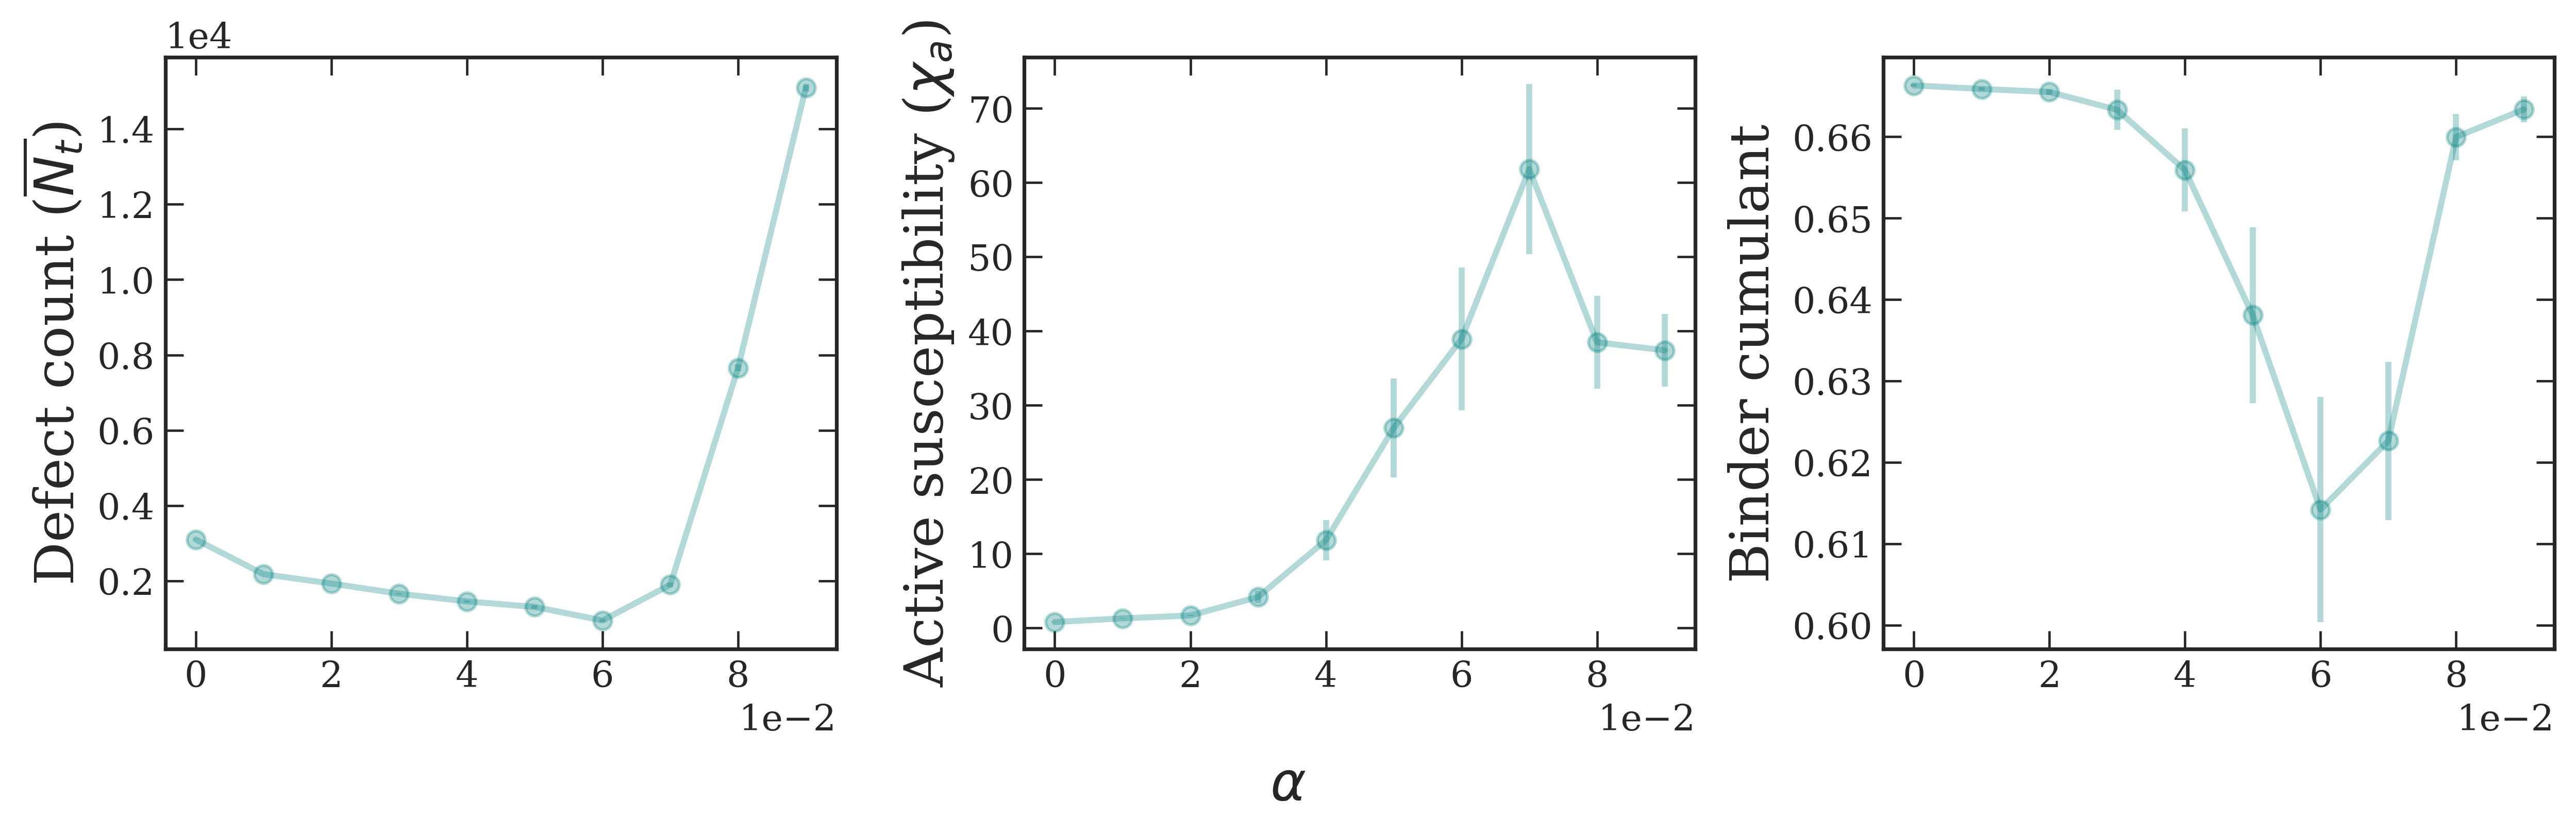

In [18]:
fig, ax = plt.subplots(ncols=3, figsize=(12,4))

ax[0].errorbar(alpha_list, av_defects[:,0], yerr = av_defects[:,1], fmt='o-', alpha=.3)
ax[0].set_ylabel(r'Defect count ($\overline{N_t}$)')

ax[1].errorbar(alpha_list, sus[:,0], yerr = sus[:,1], fmt='o-', alpha=.3)
ax[1].set_ylabel(r'Active susceptibility ($\chi_a$)')

ax[2].errorbar(alpha_list, binder_cumulants[:,0], yerr = binder_cumulants[:,1], fmt='o-', alpha=.3)
ax[2].set_ylabel('Binder cumulant')


fig.supxlabel(r'$\alpha$', y=0.05)
fig.tight_layout()

#### Density fluctuations

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
for i, alpha in enumerate(alpha_list):
    ax.errorbar(window_sizes, av_counts_av[i,:,0], yerr = av_counts_av[i,:,1], fmt='o-', alpha=.3, label = f'alpha = {alpha}')

ax.set_xlabel(r'Window size ($R$)')
ax.set_ylabel(r'Defect count ($\overline{N}(R)$)')
#ax.set_xscale('log')    
#ax.set_yscale('log')
ax.legend(fontsize=12)

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
for i, alpha in enumerate(alpha_list):
    ax.errorbar(window_sizes, av_counts_av2[i,:,0], yerr = av_counts_av2[i,:,1], fmt='o-', alpha=.3, label = f'alpha = {alpha}')

ax.set_xlabel(r'Window size ($R$)')
ax.set_ylabel(r'Defect count ($\overline{N}(R)$)')
#ax.set_xscale('log')    
#ax.set_yscale('log')
ax.legend(fontsize=12)

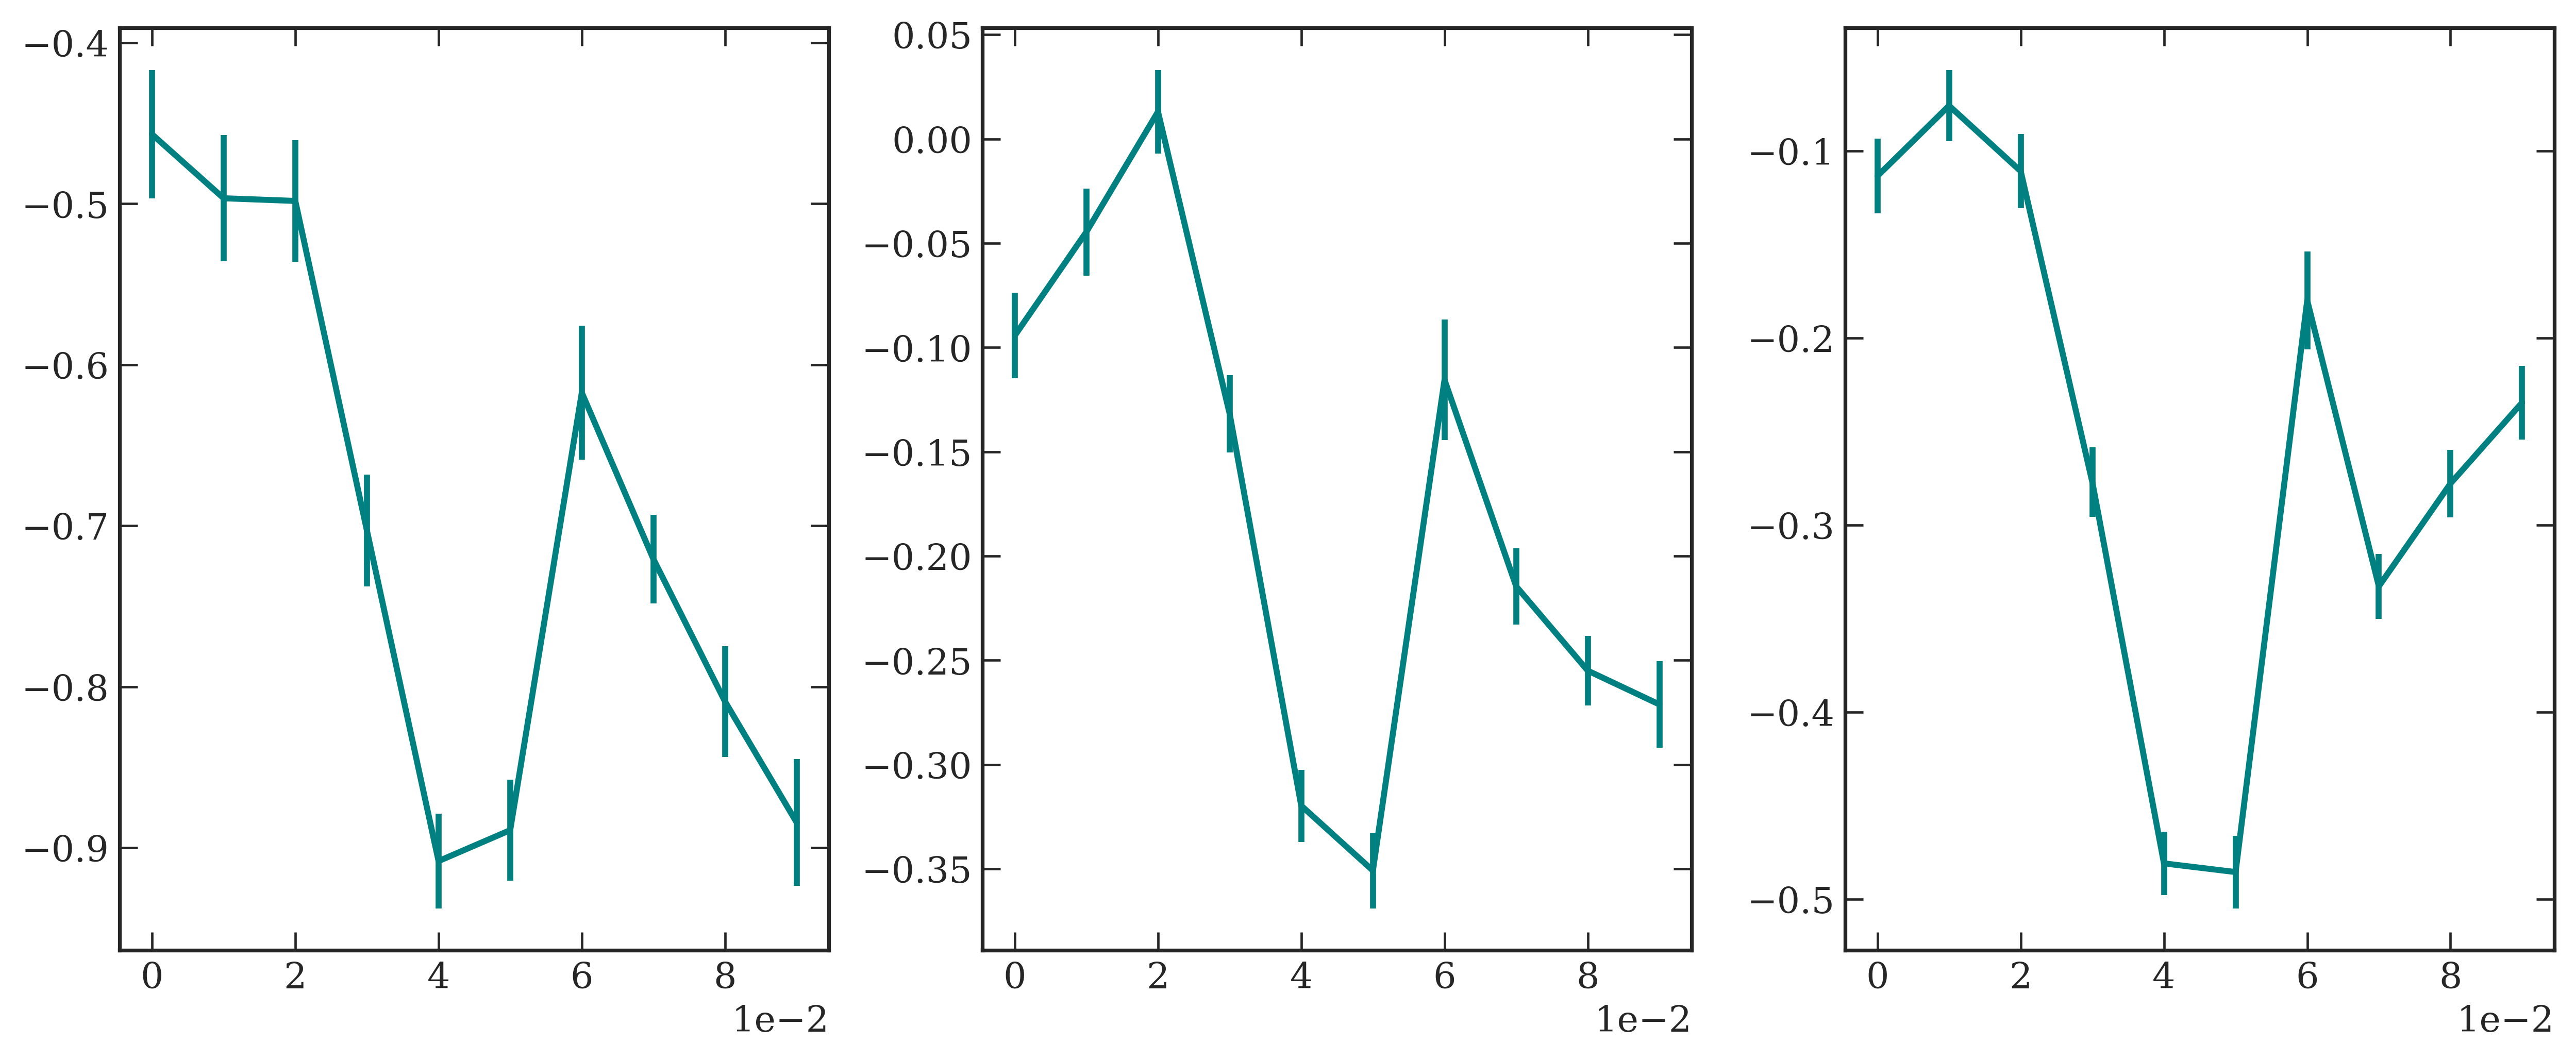

In [12]:

fig, ax = plt.subplots(ncols=3, figsize=(12,5))

for (axx, vars) in zip(ax,[var_counts_av, var_counts_av2, var_counts_non]):
    
#var_std_est = np.sqrt(var_counts_av[:,:,0], ) / np.sqrt(var_counts_av[:,:,0].shape[1])
    var_std_est = np.zeros((Nwindows, len(alpha_list)))
    for i in range(len(alpha_list)):
        var_std_est[:,i] = np.nanmean(var_counts[int(conv_list[i]):,:, i], axis=0) / np.sqrt(var_counts[int(conv_list[i]):,:, i].shape[0])
    #var_std_est = np.nanmean(var_counts[conv_list[i]:,:, i,], axis=0) / np.sqrt(var_counts[conv_list[i]:, :, i].shape[0])
    var_std_est = np.swapaxes(var_std_est, 0, 1)
    fitp, stat_arr = analyze_hyperuniformity(window_sizes, vars[:,:,0], var_std_est, window_idx_bounds = [25,50], act_idx_bounds = [0, None])
    fitp, stat_arr[:,-1]

    axx.errorbar(alpha_list, fitp[:,0], fitp[:,2],)

In [14]:
window_sizes

array([ 10.24      ,  15.2555102 ,  20.27102041,  25.28653061,
        30.30204082,  35.31755102,  40.33306122,  45.34857143,
        50.36408163,  55.37959184,  60.39510204,  65.41061224,
        70.42612245,  75.44163265,  80.45714286,  85.47265306,
        90.48816327,  95.50367347, 100.51918367, 105.53469388,
       110.55020408, 115.56571429, 120.58122449, 125.59673469,
       130.6122449 , 135.6277551 , 140.64326531, 145.65877551,
       150.67428571, 155.68979592, 160.70530612, 165.72081633,
       170.73632653, 175.75183673, 180.76734694, 185.78285714,
       190.79836735, 195.81387755, 200.82938776, 205.84489796,
       210.86040816, 215.87591837, 220.89142857, 225.90693878,
       230.92244898, 235.93795918, 240.95346939, 245.96897959,
       250.9844898 , 256.        ])

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
for i, alpha in enumerate(alpha_list):
  #  ax.errorbar(window_sizes, var_counts_av[i,:,0], yerr = av_counts_av[i,:,1], fmt='o-', alpha=.3, label = f'alpha = {alpha}')
    ax.plot(window_sizes, var_counts_av[i,:,0], 'o-', alpha=.3, label = rf'$\alpha$ = {alpha}')


ax.plot(window_sizes, .3*window_sizes ** 2 / window_sizes[0]**2, 'k--', label = r'$R^2$')  
ax.set_xlabel(r'Window size ($R$)')
ax.set_ylabel(r'$\overline{N^2} - \overline{N}^2$')

ax.set_xscale('log')    
ax.set_yscale('log')
ax.legend(fontsize=10,ncols=2)

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
for i, alpha in enumerate(alpha_list):
  #  ax.errorbar(window_sizes, av_counts_av[i,:,0], yerr = av_counts_av[i,:,1], fmt='o-', alpha=.3, label = f'alpha = {alpha}')
    ax.plot(window_sizes, var_counts_av2[i,:,0], 'o-', alpha=.3, label = rf'$\alpha$ = {alpha}')


ax.plot(window_sizes, 5.9*window_sizes ** 2 / window_sizes[0]**2, 'k--', label = r'$R^2$')  
ax.set_xlabel(r'Window size ($R$)')
ax.set_ylabel(r'$\overline{N^2} - \overline{N}^2$')

ax.set_xscale('log')    
ax.set_yscale('log')
ax.legend(fontsize=10,ncols=2)

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
marker_shape = ['s', 'o', '^', 'v', 'D', 'P', 'X', 'h', 'd', 'p', 'H', '8', '1', '2']
for i, alpha in enumerate(alpha_list):
    
  if alpha in [.01, .07, .08, .09]:
    continue

  #  ax.errorbar(window_sizes, av_counts_av[i,:,0], yerr = av_counts_av[i,:,1], fmt='o-', alpha=.3, label = f'alpha = {alpha}')
  ax.plot(av_counts_av[i,:,0], np.sqrt(var_counts_av[i,:,0]), marker=marker_shape[i], alpha=.3, label = rf'$\alpha$ = {alpha}')

x = np.arange(10,5e2)
X5, Y5 = produce_scaling(x, 0.55, 1.8, [0,None])
X6, Y6 = produce_scaling(x, 0.55, 4, [0,None])
X7, Y7 = produce_scaling(x, 0.7, 4.5, [0,None])
ax.plot(X5, Y5, 'k--', lw=1) #label = r'$\sim N^{0.5}$')
#ax.plot(X7, Y7, 'k--', )#label = r'$\sim N^{0.7}$')
ax.plot(X6, Y6, 'k--', lw=1)#label = r'$\sim N^{0.6}$')
ax.text(150,4, r'$\sim \overline{N}^{0.5}$', fontsize=14)
ax.text(180,110, r'$\sim \overline{N}^{0.7}$', fontsize=14)
#ax.plot(window_sizes, window_sizes ** 2 / window_sizes[0]**2, 'k--', label = r'$R^2$')  
#ax.plot(np.arange(2,1e3), np.arange(2,1e3)**0.5, 'k--', label = r'$\sim N^{0.5}$')
#ax.plot(np.arange(2,1e3), np.arange(2,1e3)**0.7, 'r--', label = r'$\sim N^{0.7}$')
#ax.plot(np.arange(2,1e3), np.arange(2,1e3)**0.8, 'b--', label = r'$\sim N^{0.8}$')

ax.set_xlabel(r'$\overline{N}$')
ax.set_ylabel(r'$\sqrt{\overline{N^2} - \overline{N}^2}$')
ax.set_xscale('log')    
ax.set_yscale('log')
ax.legend(fontsize=10,ncol=2)
#
ax.set_xlim(10,1e3)  
#ax.legend(fontsize=12)

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
marker_shape = ['s', 'o', '^', 'v', 'D', 'P', 'X', 'h', 'd', 'p', 'H', '8', '1', '2']
for i, alpha in enumerate(alpha_list):
    
  if alpha in [.01, .07, .08, .09]:
    continue

  #  ax.errorbar(window_sizes, av_counts_av[i,:,0], yerr = av_counts_av[i,:,1], fmt='o-', alpha=.3, label = f'alpha = {alpha}')
  ax.plot(av_counts_non[i,:,0], np.sqrt(var_counts_non[i,:,0]), marker=marker_shape[i], alpha=.3, label = rf'$\alpha$ = {alpha}')

x = np.arange(1,2e2)
X5, Y5 = produce_scaling(x, 0.5, .9, [0,None])
X6, Y6 = produce_scaling(x, 0.55, 4.1, [0,None])
X7, Y7 = produce_scaling(x, 0.7, 2.5, [0,None])
ax.plot(X5, Y5, 'k--', lw=1) #label = r'$\sim N^{0.5}$')
#ax.plot(X7, Y7, 'k--', )#label = r'$\sim N^{0.7}$')
ax.plot(X7, Y7, 'k--', lw=1)#label = r'$\sim N^{0.6}$')
ax.text(150,4, r'$\sim \overline{N}^{0.5}$', fontsize=14)
ax.text(180,110, r'$\sim \overline{N}^{0.7}$', fontsize=14)
#ax.plot(window_sizes, window_sizes ** 2 / window_sizes[0]**2, 'k--', label = r'$R^2$')  
#ax.plot(np.arange(2,1e3), np.arange(2,1e3)**0.5, 'k--', label = r'$\sim N^{0.5}$')
#ax.plot(np.arange(2,1e3), np.arange(2,1e3)**0.7, 'r--', label = r'$\sim N^{0.7}$')
#ax.plot(np.arange(2,1e3), np.arange(2,1e3)**0.8, 'b--', label = r'$\sim N^{0.8}$')

ax.set_xlabel(r'$\overline{N}$')
ax.set_ylabel(r'$\sqrt{\overline{N^2} - \overline{N}^2}$')
ax.set_xscale('log')    
ax.set_yscale('log')
ax.legend(fontsize=10,ncol=2)
#
ax.set_xlim(10,1e3)  
#ax.legend(fontsize=12)

In [10]:
sfac_reshaped = np.swapaxes(sfac_av, axis1=0, axis2=1)
fit_params = analyze_sfac_time_av(kbins, sfac_reshaped, Npoints_bounds = [3,6],)
fit_params

array([[-0.00630578, -0.14950469,  0.01083137,  0.04020116],
       [-0.04009609,  0.10813576,  0.00985883,  0.03650333],
       [-0.04419208,  0.32875344,  0.01164952,  0.04320938],
       [-0.12026593,  0.4703433 ,  0.05151308,  0.191409  ],
       [-0.36962724,  0.1110386 ,  0.05847159,  0.21739912],
       [-0.66066612, -0.40281986,  0.06294742,  0.23429956],
       [-0.89215439, -0.65926058,  0.07124439,  0.26785853],
       [-0.85806256, -0.1243985 ,  0.05096685,  0.18814311],
       [-0.47673635,  1.33042062,  0.04203665,  0.15559021],
       [-0.40151482,  1.6831124 ,  0.0331057 ,  0.12276964]])

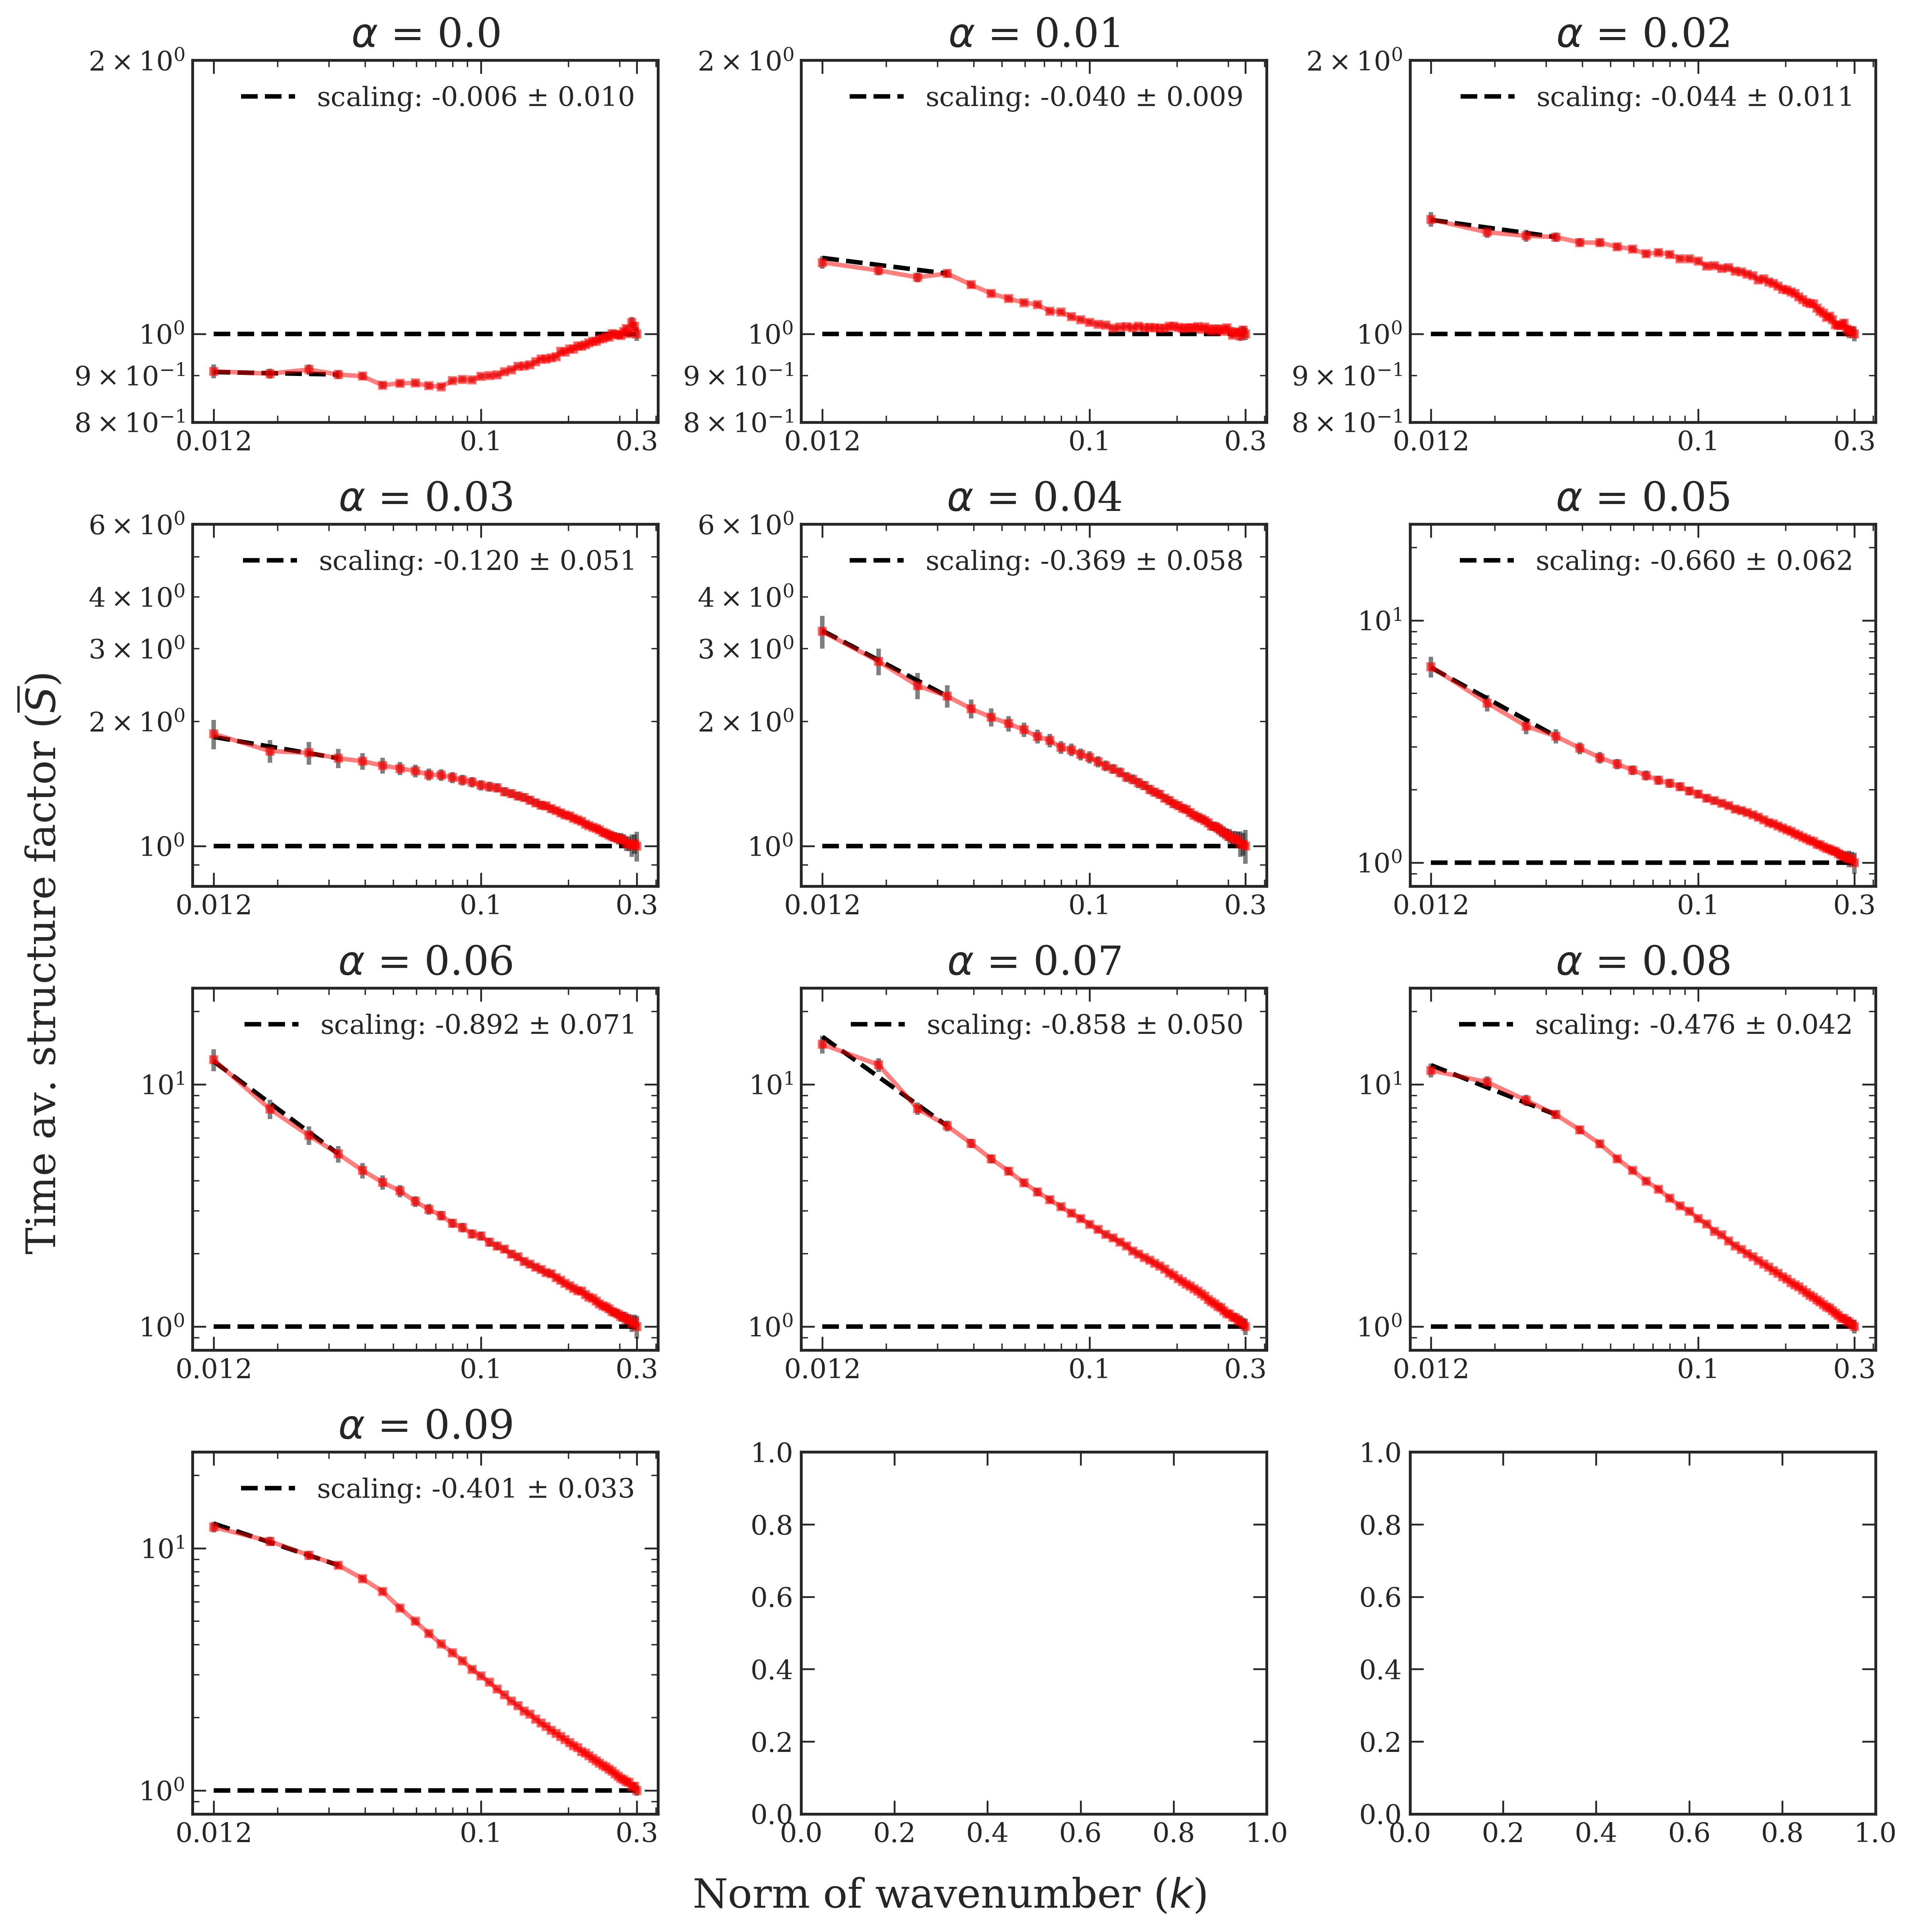

In [31]:
normalize = True
nrows = int(np.ceil(len(act_list) / 3)) #if len(act_list) % 3 != 0 else len(act_list) // 3
fig, ax = plt.subplots(ncols = 3, nrows = nrows, figsize=(12, 3*nrows))
ax = ax.flatten()

scaling_exp_list = fit_params[:,0] #[0, -0.05, -.05, -.1, -.3, -.7, -.85, -.6, -.5]
scaling_err_list = fit_params[:,2] #[
scaling_label_list = [fr'scaling: {str(i)[:6]} $\pm$ {str(j)[:5]}' for i,j in zip(scaling_exp_list, scaling_err_list)]
#scaling_label_list = len(alpha_list) * [r'$k^{-0.2}$']  

for i, alpha in enumerate(alpha_list):	
    normalizer = sfac_av[i,-1,0] if normalize else 1
    axx = plot_structure_factor(kbins, sfac_av[i,:,0]/normalizer, sfac_av[i,:,1]/normalizer, ax = ax[i], 
                                Npoints_to_fit=4,
                          LX=1024, scaling_exp_list = scaling_exp_list, scaling_label_list = scaling_label_list)
    if i < 3:
        axx.set_ylim([0.8,2])
    elif 3 <= i < 5:
        axx.set_ylim([0.8, 6])
    else:
        axx.set_ylim([0.8, 25])
    axx.legend(fontsize=12)
    axx.title.set_text(rf'$\alpha$ = {alpha}')  
fig.supxlabel(r'Norm of wavenumber ($k$)')
fig.supylabel(r'Time av. structure factor ($\overline{S}$)');

In [9]:
def plot_structure_factor(kbins, smeans, sstds, k = None, LX = None, scaling_exp_list=[], scaling_label_list=[], Npoints_to_fit=10, ax=None, sf_estimated = None):
    """
    Plot structure factor
    """

    k_begin_lines_idx = Npoints_to_fit - 1  
    kmin, kmax = np.nanmin(kbins), np.nanmax(kbins)
    sf_min, sf_max = np.nanmin(smeans), np.nanmax(smeans)
    x = np.linspace(kmin, kbins[k_begin_lines_idx], 10)

    if ax is None:
        fig, ax = plt.subplots(figsize=(9, 6))
        subplot = False
    else:
        subplot = True


    if k and sf_estimated:
        ax.scatter(np.linalg.norm(k, axis = 1), sf_estimated, label='Structure factor', s=2.5, alpha=0.3)

    ax.hlines(1, x[0], kmax, linestyles='dashed', colors='k')
    ax.errorbar(kbins, smeans, yerr = sstds, fmt = 's-', alpha = .5, color = 'red', ecolor = 'black', markersize = 3)

    if len(scaling_exp_list) > 0:
        x = kbins[:Npoints_to_fit]
        scaling_exp = scaling_exp_list[i]
        label = scaling_label_list[i] if len(scaling_label_list) > 0 else None
        ax.plot(x, smeans[k_begin_lines_idx] * x**scaling_exp / x[-1]**scaling_exp, '--', color='k',lw=2, label = label, alpha=1,) 
 
    ax.set_xscale('log')
    ax.set_yscale('log')

    if LX == 2048:
            ax.set_xticks([kmin, 0.01, 0.1, kmax], [np.round(kmin,3), 0.01, 0.1, np.round(kmax,1)])
            ax.set_yticks([0.3, 0.4, 0.6, 1, 5], [0.3, 0.4, 0.6, 1, 5])
    else:
        ax.set_xticks([kmin, 0.1, kmax], [np.round(kmin,3), 0.1, np.round(kmax,1)])
    #    ax.set_yticks([0.3, 0.4, 0.6, 1,], [0.3, 0.4, 0.6, 1,])

    if subplot:
        return ax
    else:
        ax.legend(ncol=3, fontsize = 14)
        ax.set_xlabel(r'Norm of wavenumber ($k$)')
        ax.set_ylabel(r'Time av. structure factor')
        fig.tight_layout()
        return fig, ax
    

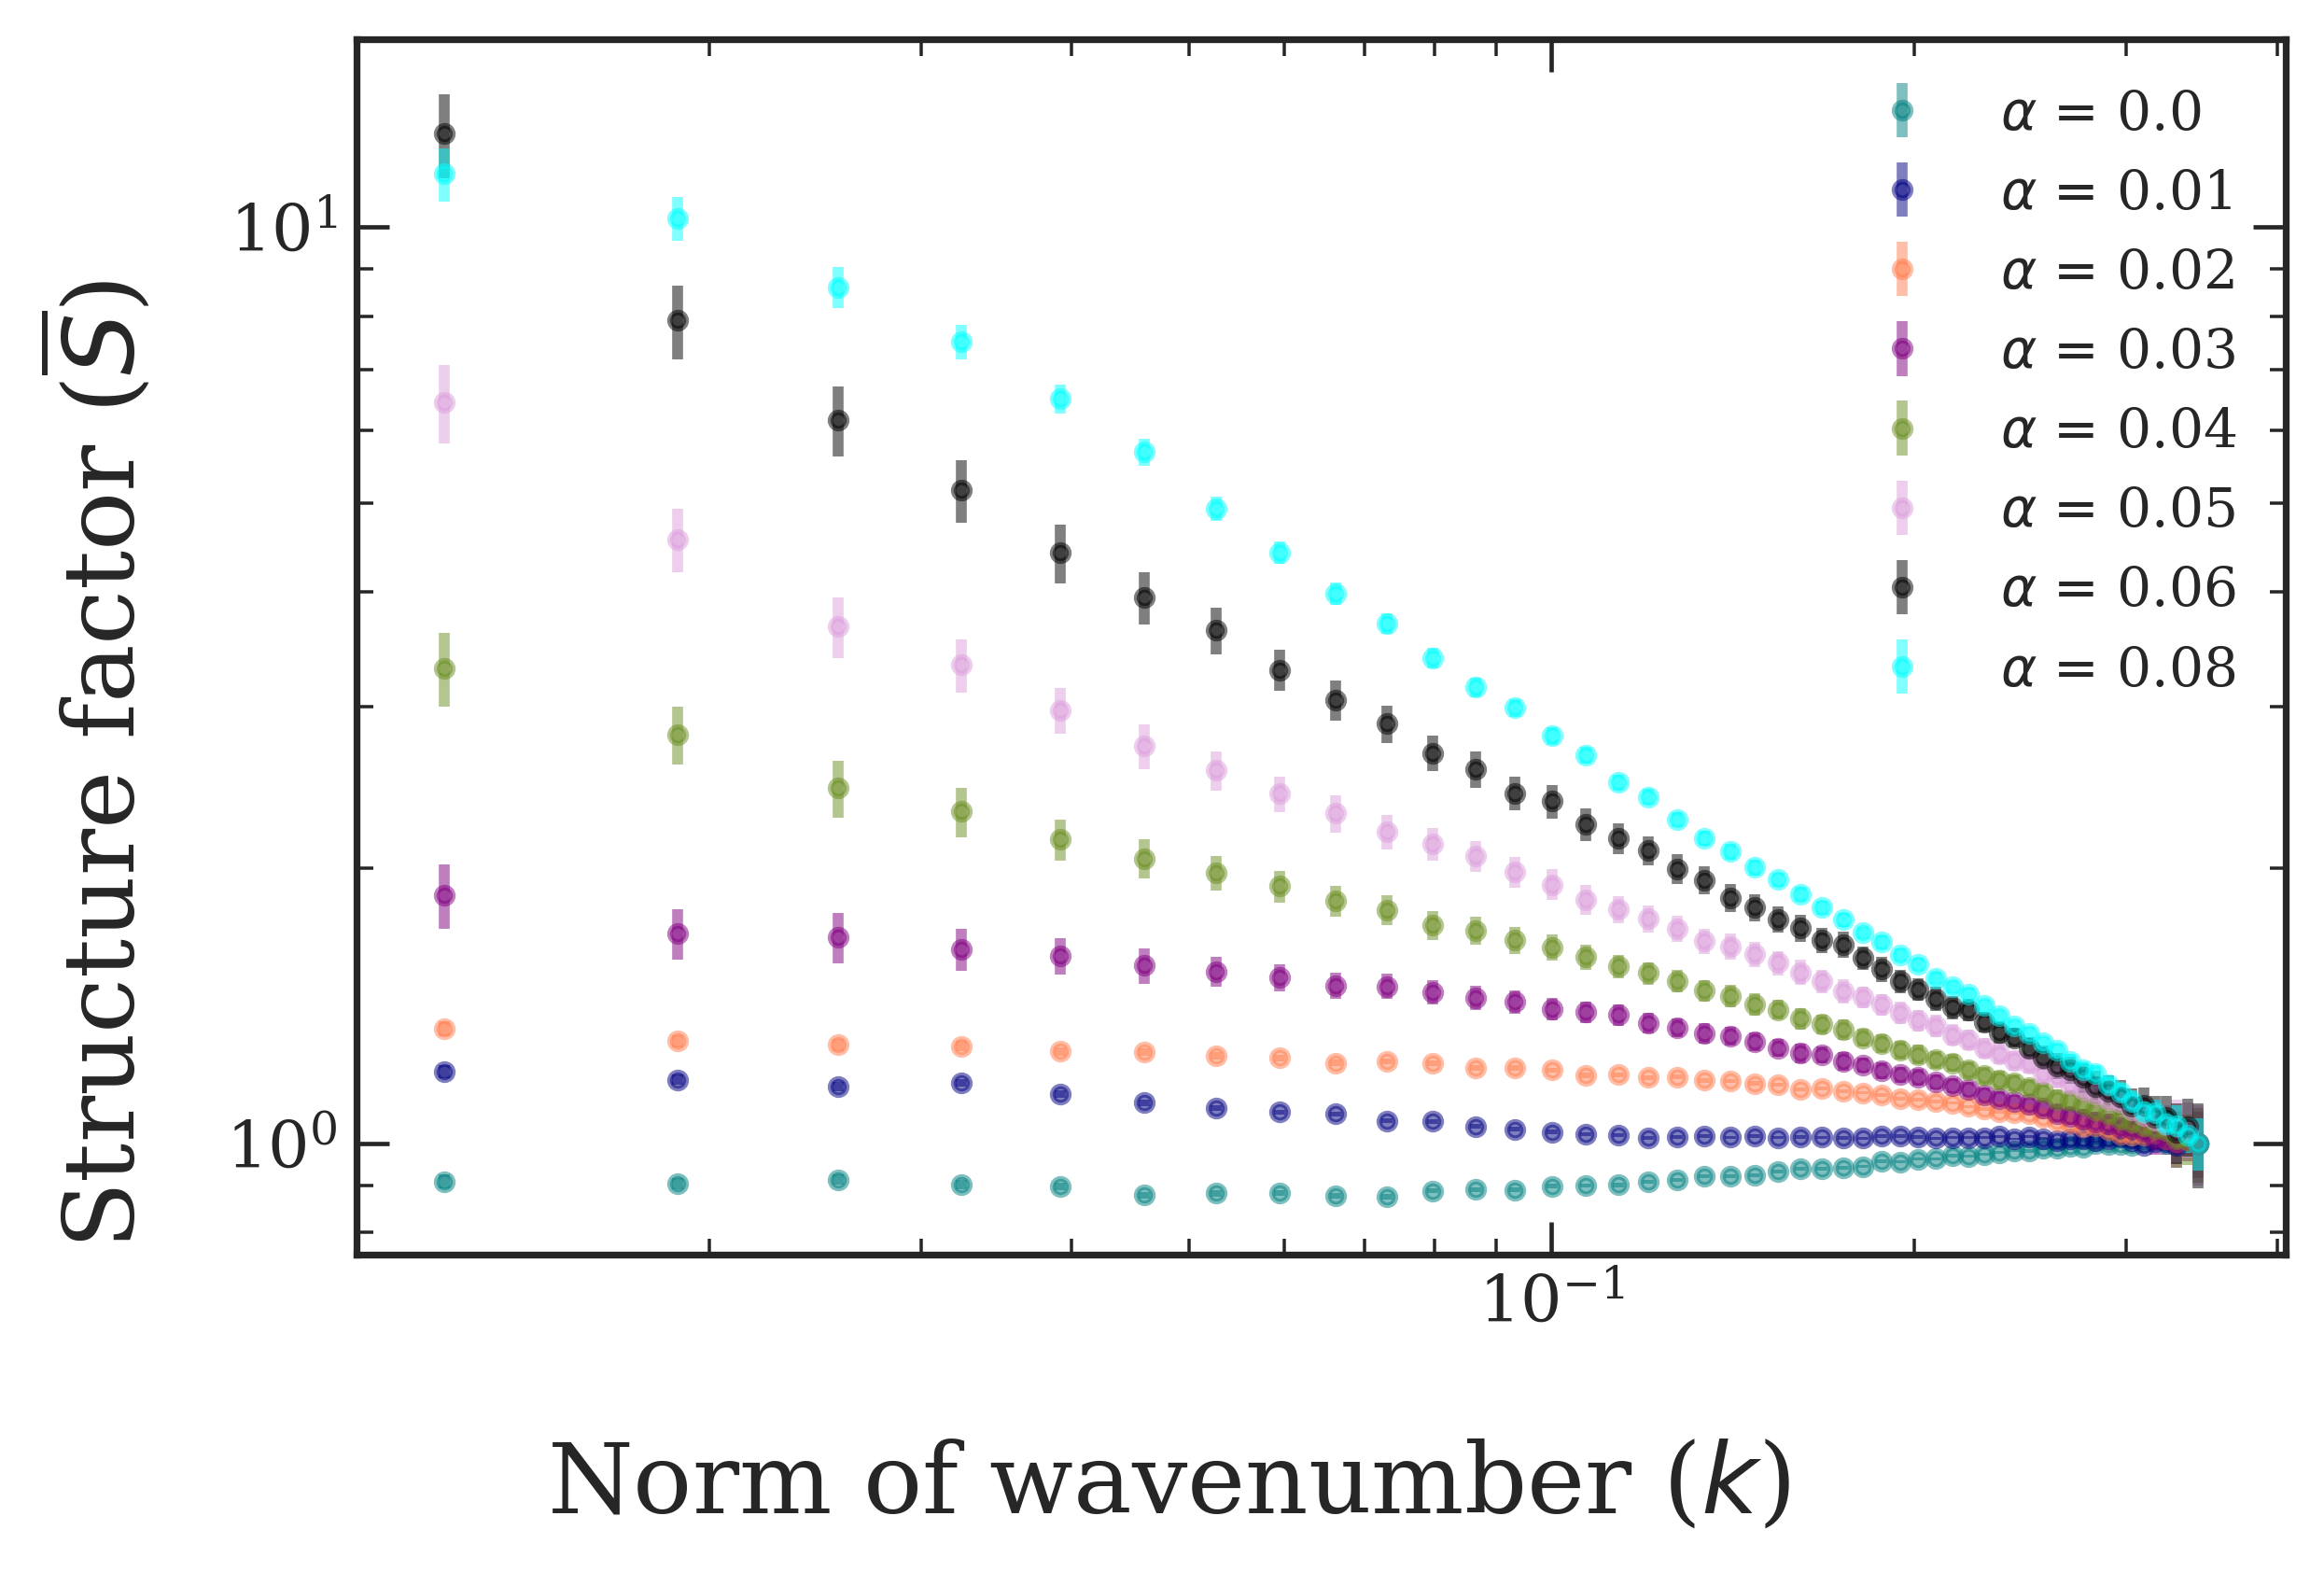

In [48]:
normalize = True
fig, ax = plt.subplots(figsize=(6,4))

scaling_exp_list = fit_params[:,0] #[0, -0.05, -.05, -.1, -.3, -.7, -.85, -.6, -.5]
scaling_err_list = fit_params[:,2] #[
scaling_label_list = [fr'scaling: {str(i)[:6]} $\pm$ {str(j)[:5]}' for i,j in zip(scaling_exp_list, scaling_err_list)]
#scaling_label_list = len(alpha_list) * [r'$k^{-0.2}$']  

for i, alpha in enumerate(alpha_list):	
    if alpha in [0.07, 0.09]:
        continue
    normalizer = sfac_av[i,-1,0] if normalize else 1
    ax.errorbar(kbins,  sfac_av[i,:,0]/normalizer, 
                yerr = sfac_av[i,:,1]/normalizer, fmt = 'o', alpha = .5, 
                color = f'C{i}', markersize = 3
                , label = rf'$\alpha$ = {alpha}')
  #  ax.errorbar(kbins,  sfac_av[i,:,0]/normalizer, yerr = sfac_av[i,:,1]/normalizer, fmt = 'o', alpha = .5, color = f'C{i}', ecolor = 'black', markersize = 3)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize=10)
 #   axx.title.set_text(rf'$\alpha$ = {alpha}')  
fig.supxlabel(r'Norm of wavenumber ($k$)')
fig.supylabel(r'Structure factor ($\overline{S}$)');

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.errorbar(act_list, fit_params[:,0], fit_params[:,2], fmt = 's-',
                alpha = .6, elinewidth=1.5, capsize=1.5, 
                capthick=1, markersize = 4, lw=1, color = f'C{0}')
ax.legend()
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(rf'Scaling exponent')
fig.tight_layout()

In [42]:
alpha_list[::2]

array([0.  , 0.02, 0.04, 0.06, 0.08])

In [85]:
av_counts_non[:,-1,0]

array([ 607.95833333,  428.4523975 ,  379.13934426,  328.17554645,
        287.32107496,  262.49663138,  188.78587699,  371.78876582,
       1494.86209335, 2977.6786655 ])

In [95]:
data_file = os.path.join(save_path, 'data.npz')
np.savez(data_file, kbins=kbins, sfac_av=sfac_av, alpha_list=alpha_list, av_counts_non = av_counts_non[:,0:25,:], \
         var_counts_non = var_counts_non[:,0:25,:], fit_params = fit_params)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


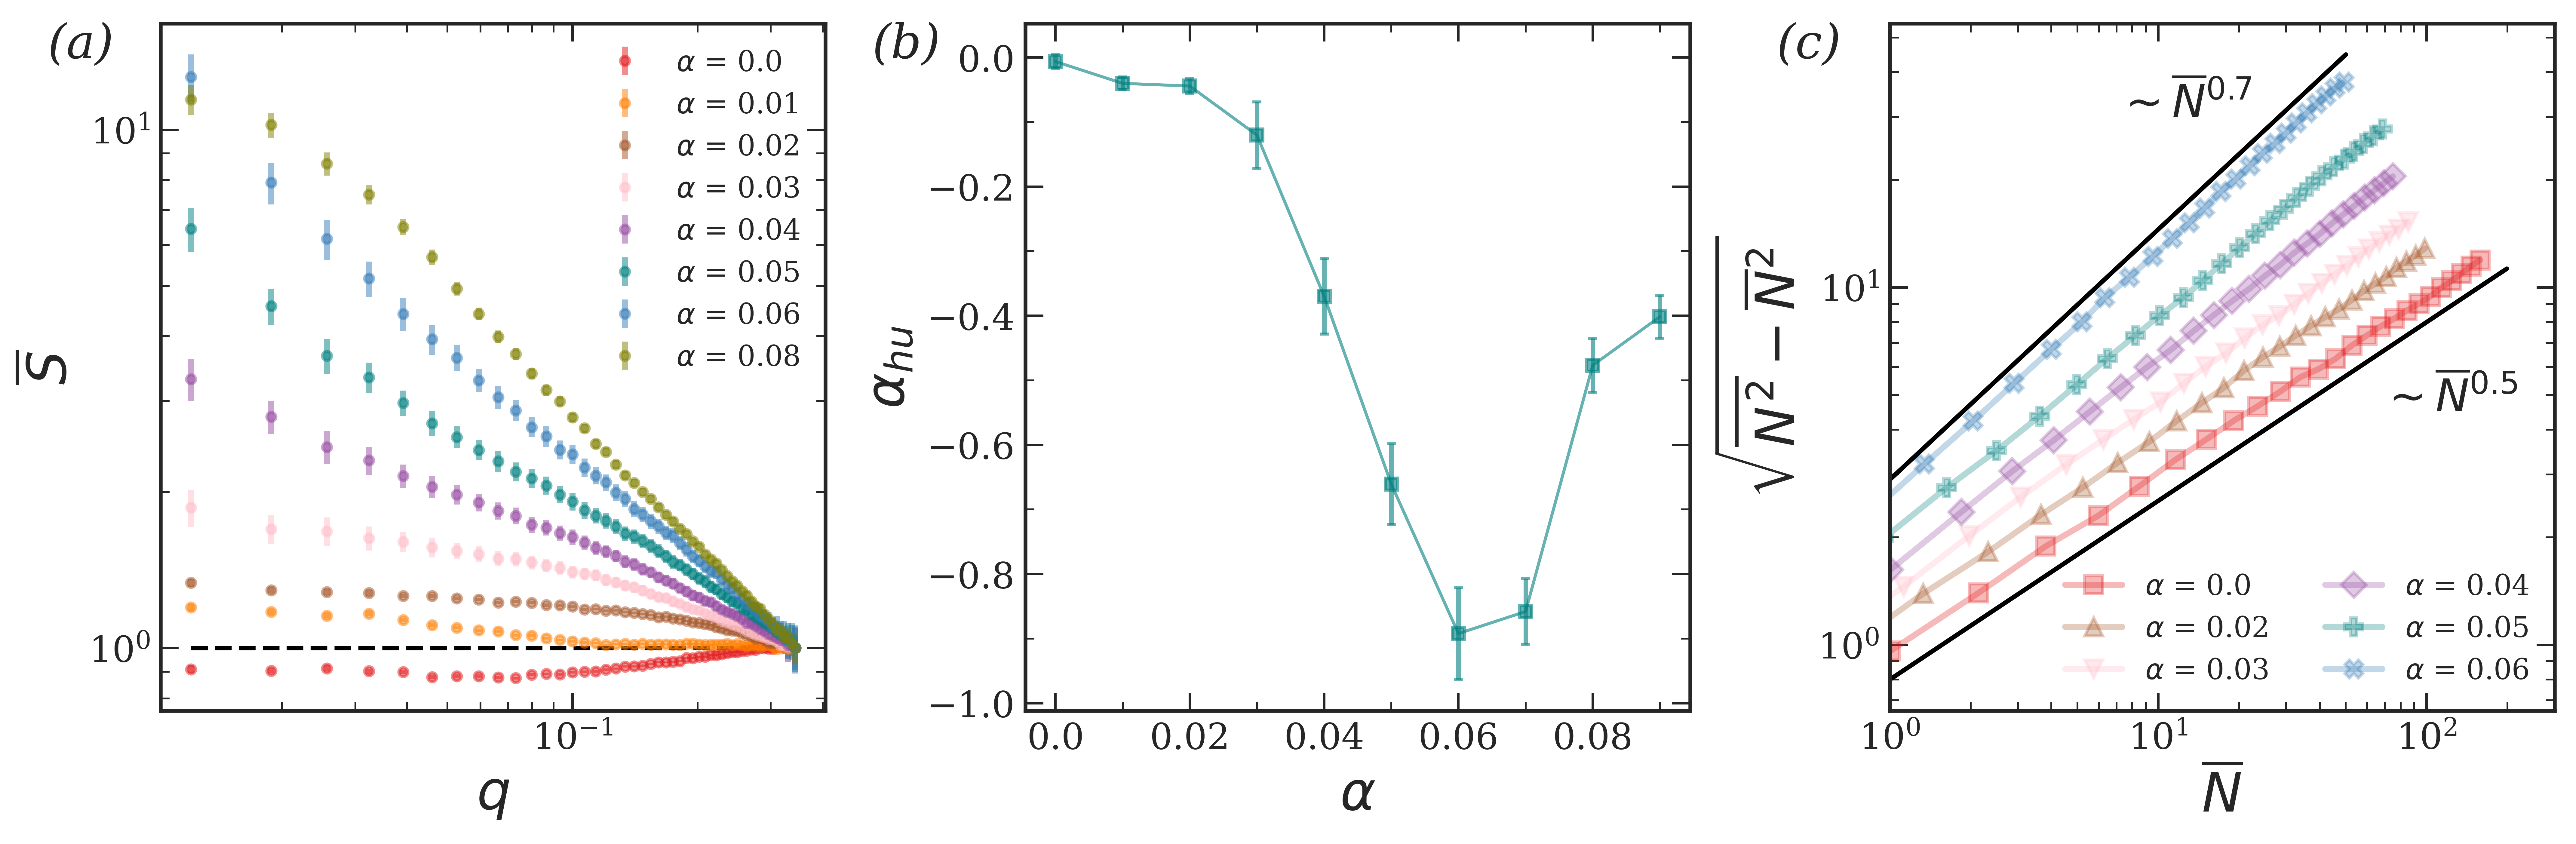

In [ ]:
plt.rcParams['text.usetex'] = False
#rcParams.update({
#    "text.usetex": True,
#})
normalize=True
fig, ax0 = plt.subplots(nrows = 1, ncols = 3, figsize=(12,4)) 
marker_shape = ['s-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']
ax0 = ax0.flatten()
axxs = ax0[0]
ax = ax0[1]
axx = ax0[-1]
act_max = 0.022

colors=['#E41A1C', '#FF7F00', '#A65628', '#FFC0CB', '#984EA3', 'teal','#377EB8', 'black','olive']
for i, alpha in enumerate(alpha_list):	
    if alpha in [0.07, 0.09]:
        continue
    alpha_idx = np.where(alpha_list==alpha)[0][0]
    normalizer = sfac_av[i,-1,0] if normalize else 1
    axxs.errorbar(kbins,  sfac_av[i,:,0]/normalizer, 
                yerr = sfac_av[i,:,1]/normalizer, fmt = 'o', alpha = .5, 
                color = f'{colors[alpha_idx]}', markersize = 3
                , label = rf'$\alpha$ = {alpha}')
    
axxs.set_xscale('log')
axxs.set_yscale('log')
axxs.legend(fontsize=9.5,ncols=1) 
axxs.set_xlabel(r'$q$', fontsize=18)
axxs.set_ylabel(r'$\overline{S}$');
axxs.hlines(1, kbins[0], kbins[-1], linestyles='dashed', colors='k', lw=1.5)

ax.errorbar(alpha_list, fit_params[:,0], fit_params[:,2], fmt = 's-',
                alpha = .6, elinewidth=1.5, capsize=1.5, 
                capthick=1, markersize = 4, lw=1, color = f'C{0}')
ax.legend()
ax.set_xticks(alpha_list[::2], alpha_list[::2])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\alpha_{hu}$')

ax.yaxis.set_minor_locator(ticker.MultipleLocator(.1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1e-2))
ax.legend()

window_idx_bounds = [0,25]

for i, alpha in enumerate(alpha_list):
    
  if alpha in [.01, .07, .08, .09]:
    continue
  alpha_idx = np.where(alpha_list==alpha)[0][0]

  axx.plot(av_counts_non[i,window_idx_bounds[0]:window_idx_bounds[1],0], np.sqrt(var_counts_non[i,window_idx_bounds[0]:window_idx_bounds[1],0]), 
              marker=marker_shape[i][:1], alpha=.3, color = f'{colors[alpha_idx]}', label = rf'$\alpha$ = {alpha}')

# plot lines
x = np.arange(1,2e2)
X5, Y5 = produce_scaling(x, 0.5, .8, [0,None])
X7, Y7 = produce_scaling(x, 0.7, 2.9, [0,50])
axx.plot(X5, Y5, 'k-', lw=1.5) #label = r'$\sim N^{0.5}$')
axx.plot(X7, Y7, 'k-', lw=1.5)#label = r'$\sim N^{0.6}$')
axx.text(67,4.5, r'$\sim \overline{N}^{0.5}$', fontsize=15)
axx.text(7,30, r'$\sim \overline{N}^{0.7}$', fontsize=15)

axx.set_xlabel(r'$\overline{N}$')
axx.set_ylabel(r'$\sqrt{\overline{N^2} - \overline{N}^2}$')
axx.set_xscale('log')    
axx.set_yscale('log')
axx.legend(fontsize=9.5,ncol=2, loc='lower right')
axx.set_xlim(1,3e2)  

import string
for n, AXX in enumerate(ax0):
    AXX.text(-.23 if n==1 else-0.17, .95
             , f'({string.ascii_lowercase[n]})', transform=AXX.transAxes,
            size=16,style='italic')

#fig.tight_layout()
fig.dpi = 720
#fig.savefig('data/nematic_analysis_all/susceptibility.eps', dpi = 720, pad_inches = .5)

In [26]:
rmax = 22
side_length= 100
rmax + np.random.rand(2) * (side_length - 2 * rmax)

array([69.37698548, 67.73197325])

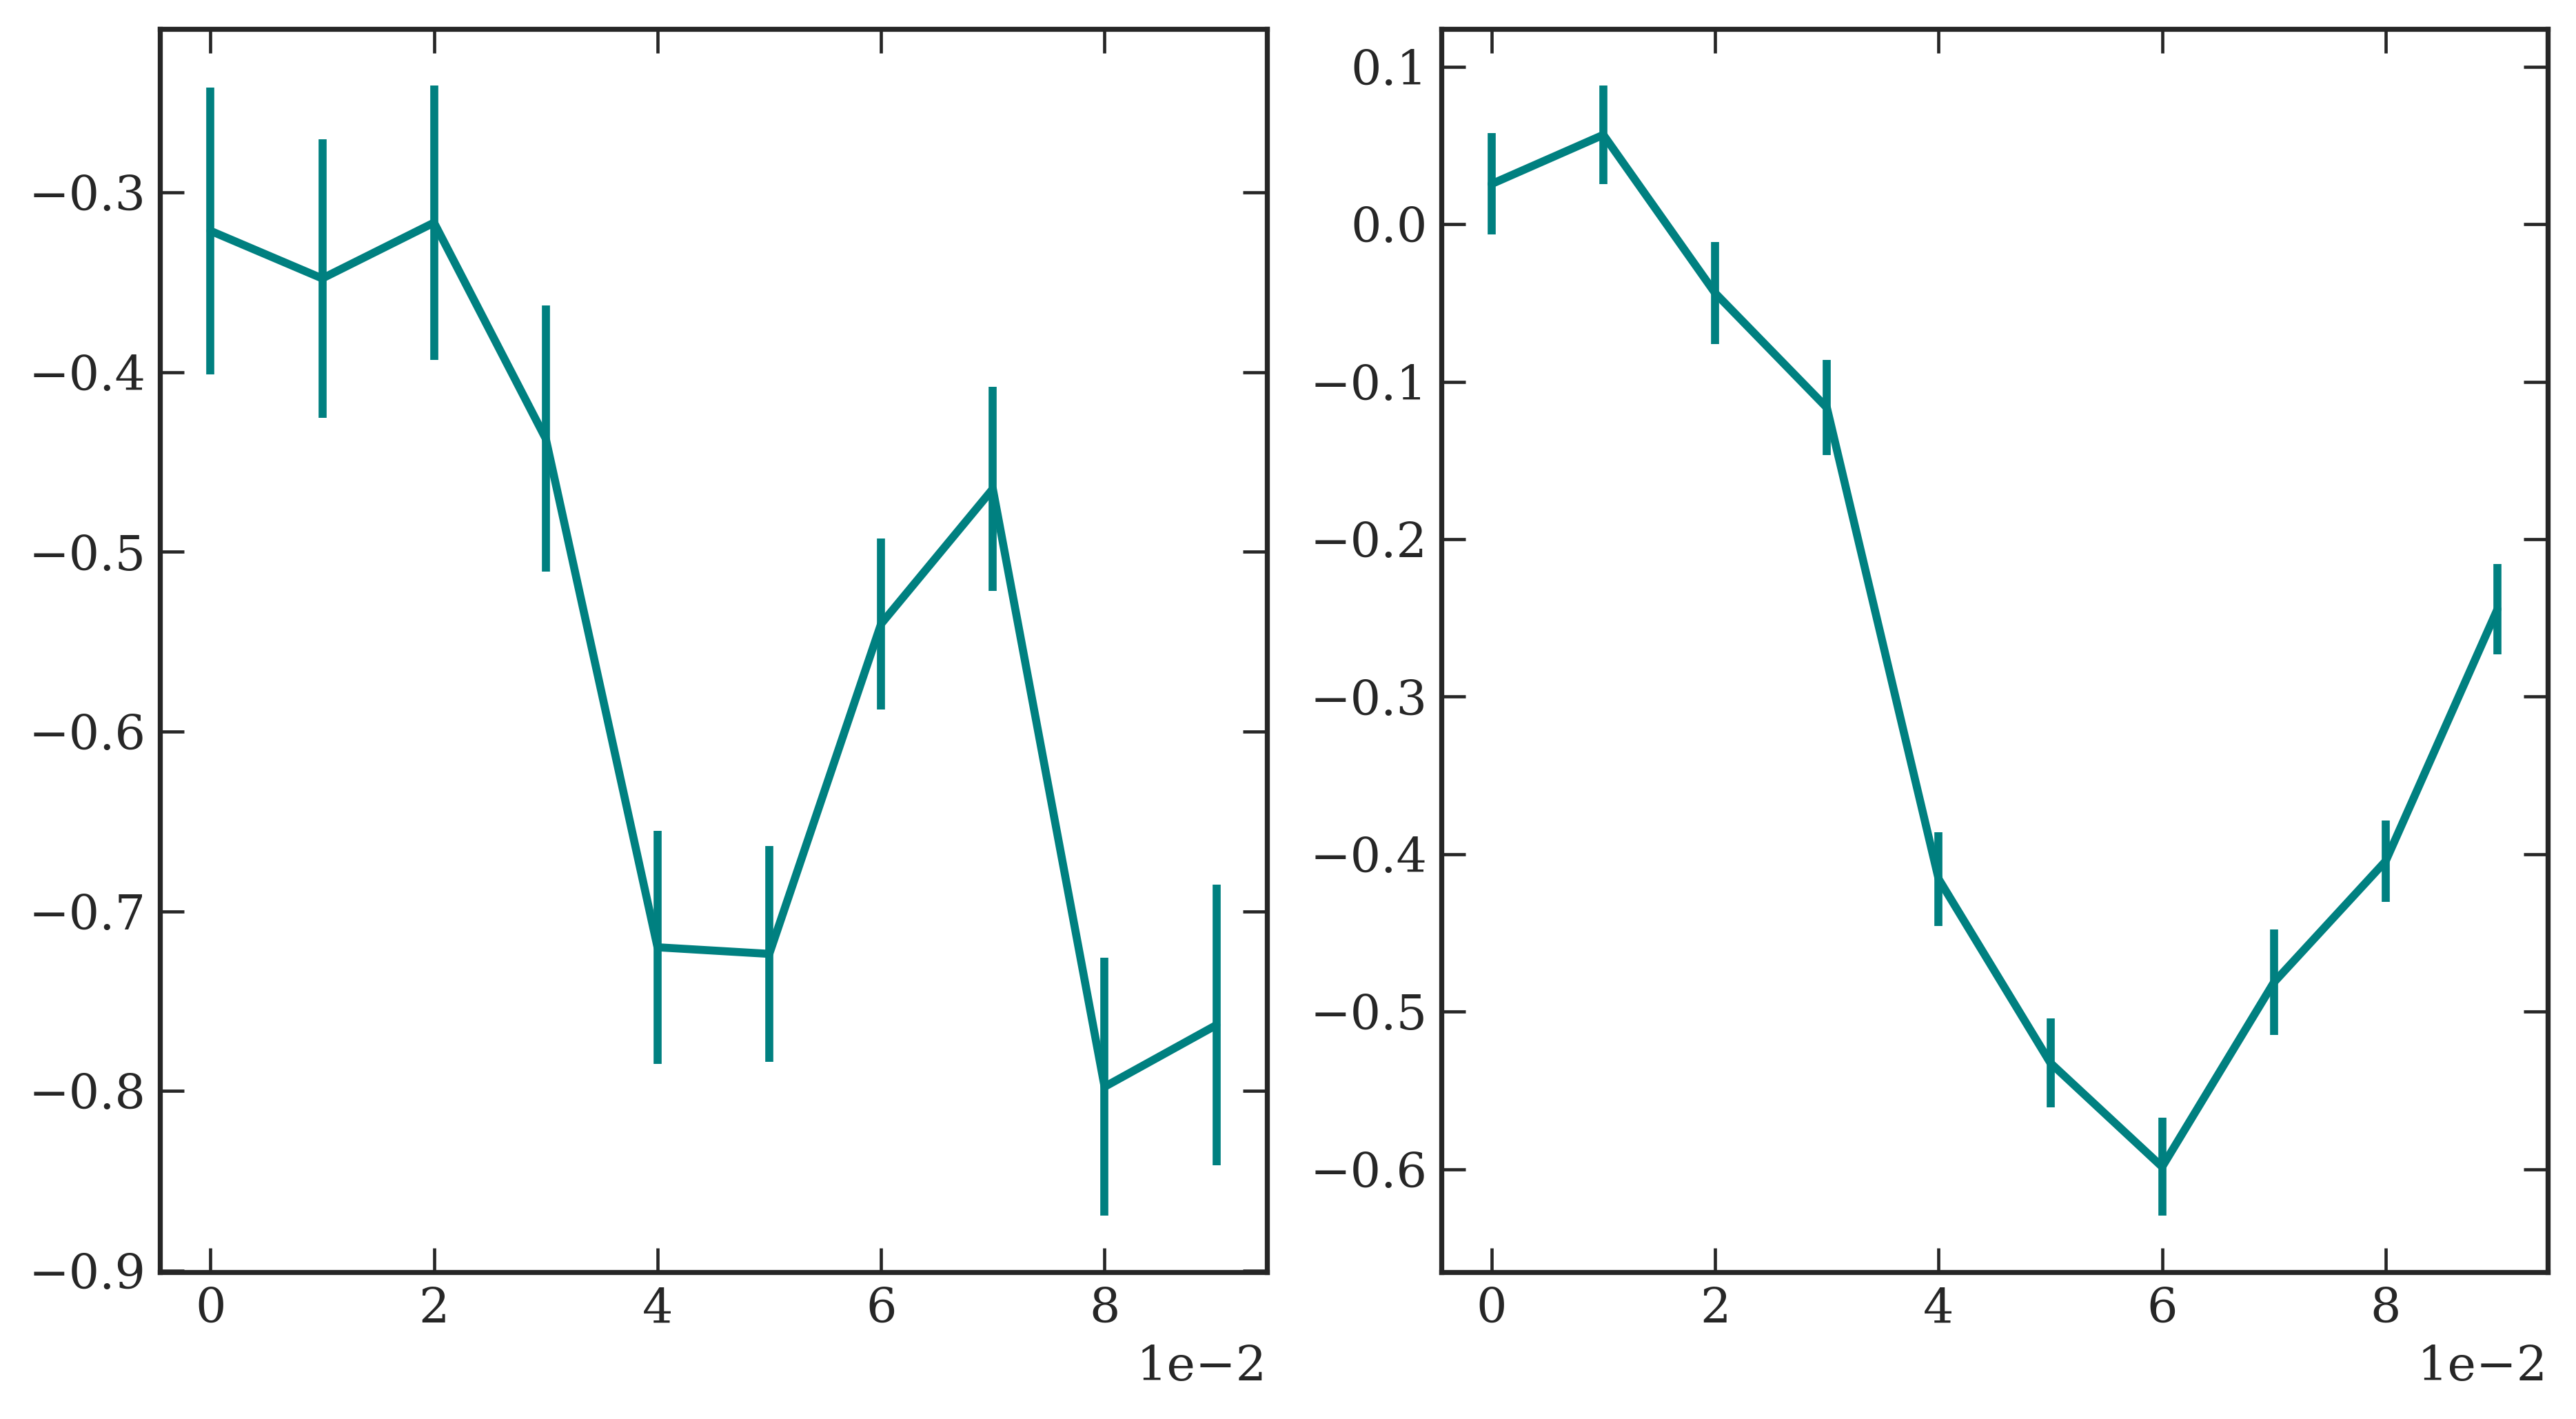

In [47]:

fig, ax = plt.subplots(ncols=2, figsize=(9,5))

for (axx, vars) in zip(ax,[var_counts_av, var_counts_av2]):

#var_std_est = np.sqrt(var_counts_av[:,:,0], ) / np.sqrt(var_counts_av[:,:,0].shape[1])
    var_std_est = np.nanmean(var_counts[-500:,:, :len(alpha_list),], axis=0) / np.sqrt(var_counts[-500:, :, :len(alpha_list)].shape[0])
    var_std_est = np.swapaxes(var_std_est, 0, 1)
    fitp, stat_arr = analyze_hyperuniformity(window_sizes, vars[:,:,0], var_std_est, window_idx_bounds = [10,30], act_idx_bounds = [0, None])
    fitp, stat_arr[:,-1]

    axx.errorbar(alpha_list, fitp[:,0], fitp[:,2],)

### Pair correlation analysis

In [49]:
rad_cutoff_arr = calc_rad_cutoff(rad, pcf_arr_av=pcf_av[:,:,0]-1, pcf_arr_std=pcf_av[:,:,1], alpha_list=alpha_list, cutoff=1e-4, rad_min=5)

# save 
np.save(os.path.join(save_path, 'rad_cutoff_arr.npy'), rad_cutoff_arr)

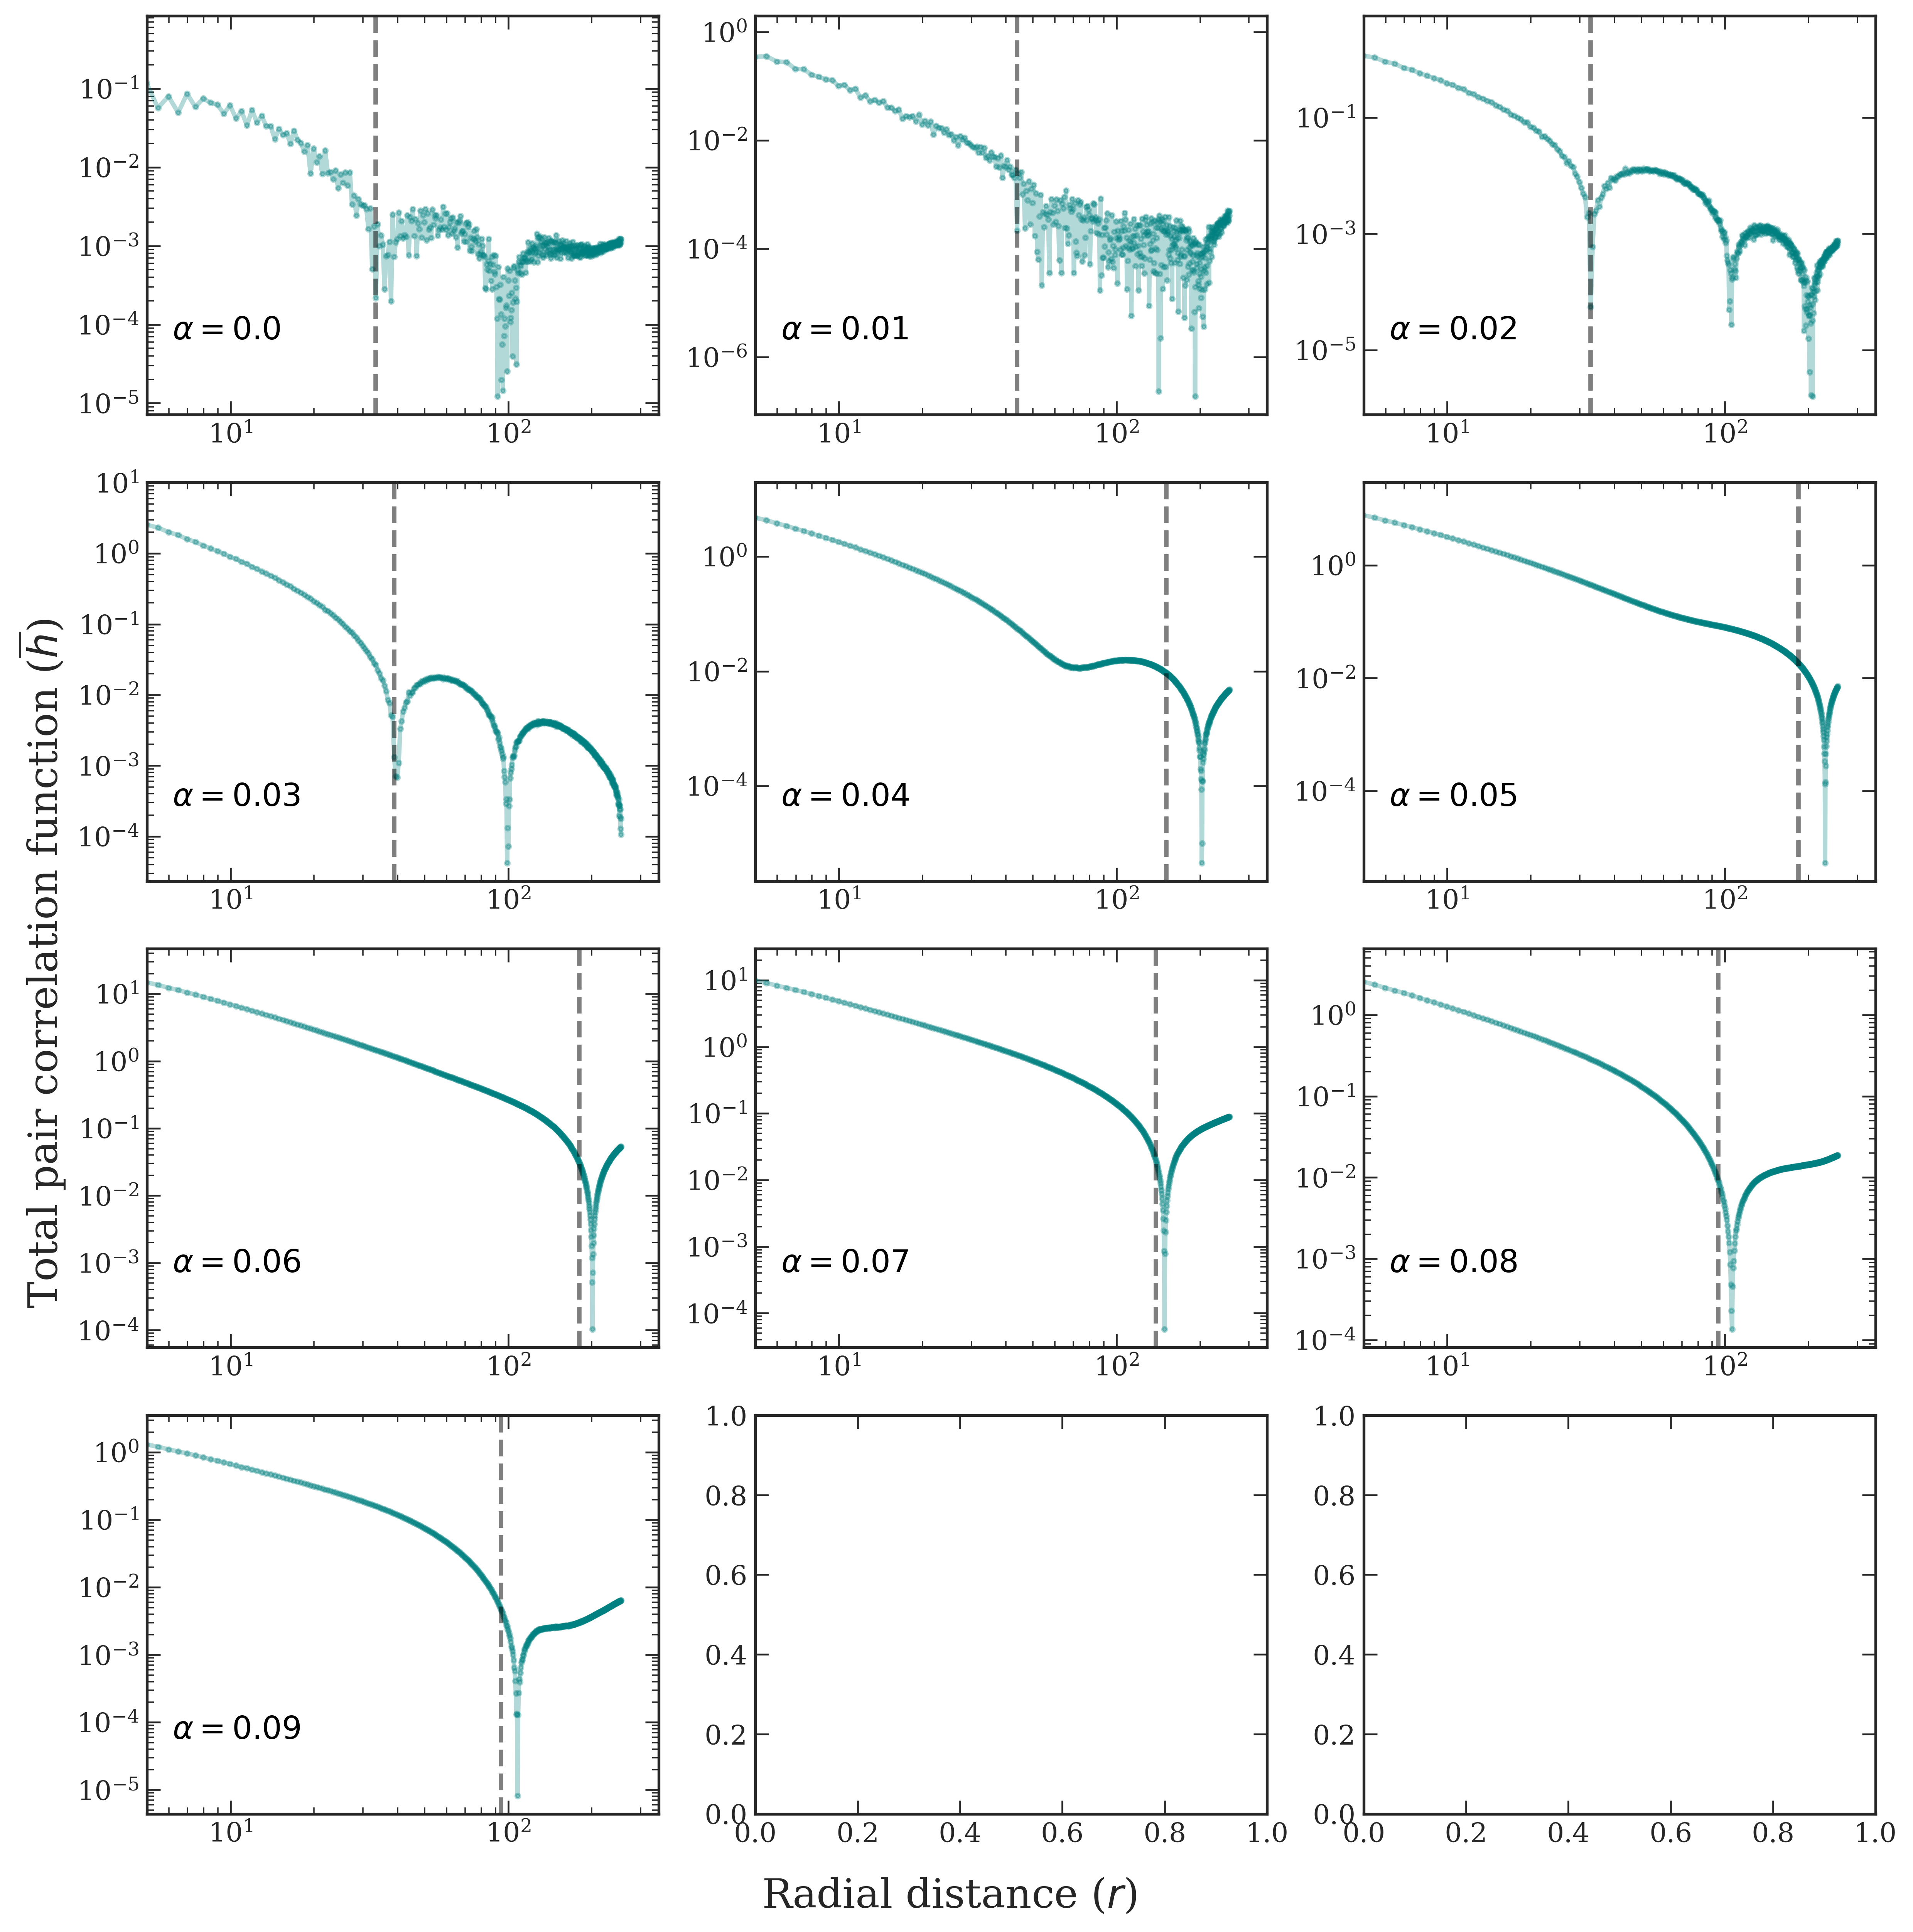

In [51]:
plot_abs = True

nrows = int(np.ceil(len(act_list) / 3))
fig, ax = plt.subplots(ncols = 3, nrows = nrows, figsize=(12, 3*nrows))
ax = ax.flatten()

for i, alpha_val in enumerate(alpha_list):
    pcf_vals = np.abs(pcf_av[i,:,0]-1) if plot_abs else pcf_av[i,:,0]-1
   # ax[i].errorbar(rad, pcf_vals, yerr = pcf_av[i,:,1], fmt='.-', alpha=.3, label = f'alpha = {alpha}')
    ax[i].plot(rad, pcf_vals, '.-', alpha=.3, ms=4) # label = f'alpha = {alpha}')
   # print(max(np.nanmax(pcf_vals),.2))
    ax[i].axvline(rad_cutoff_arr[i], 1e-4, 1, color='black', linestyle='--', alpha=0.5)

    ax[i].text(0.05, 0.25, rf'$\alpha ={alpha_val}$', fontsize=14, transform=ax[i].transAxes, verticalalignment='top', color='black')
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_xlim(xmin=5)

   # ax[i].legend(fontsize=12)

fig.supxlabel(r'Radial distance ($r$)')
fig.supylabel(r'Total pair correlation function ($\overline{h}$)');

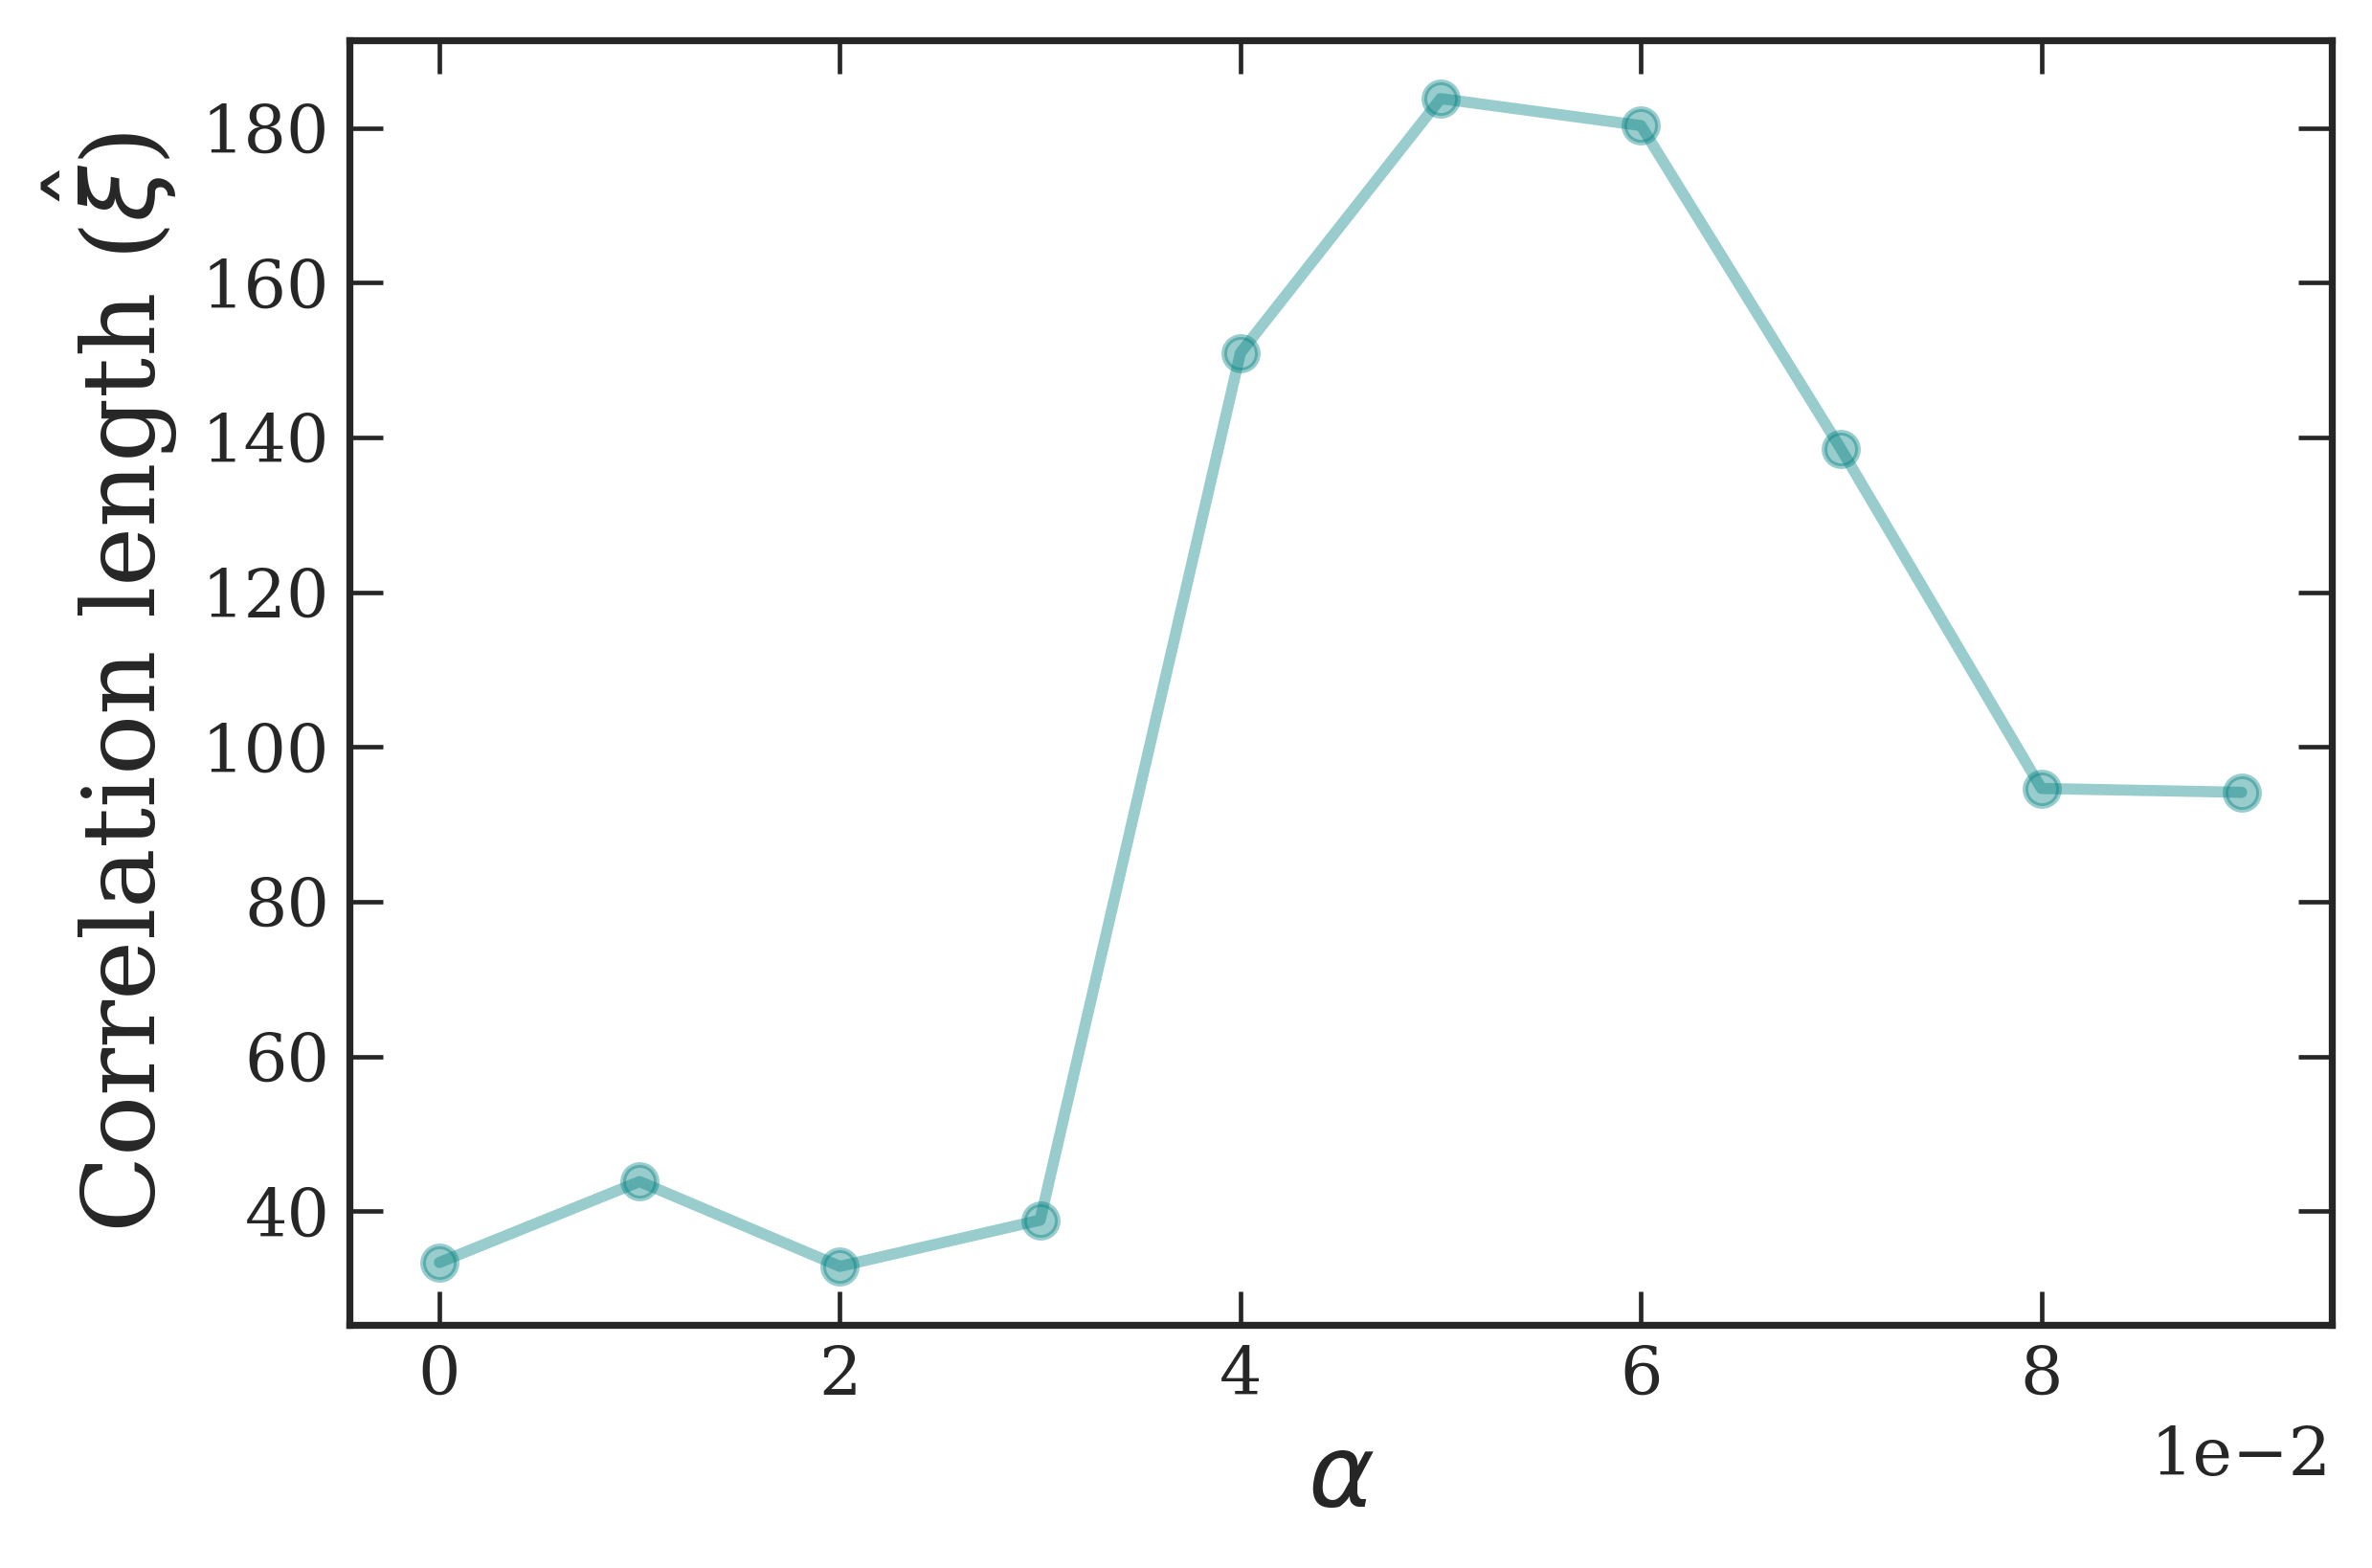

In [52]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(alpha_list, rad_cutoff_arr, 'o-', alpha=.4)
ax.set_ylabel(r'Correlation length ($\hat{\xi}$)')
ax.set_xlabel(r'$\alpha$');
#ax.set_xscale('log') 
save_path = ''